In [26]:
# ===================================================================
# ÉTAPE 0 : IMPORTS ET CONFIGURATION
# ===================================================================
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.stats import qmc # Pour le Latin Hypercube Sampling
from scipy.optimize import brentq, minimize # Pour l'inversion et la calibration
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm # Barre de progression
import scipy.integrate as integrate
# Configuration pour des résultats reproductibles
tf.random.set_seed(42)
np.random.seed(42)

# ÉTAPE 1 : LE PRICEUR HESTON "ORACLE"

In [27]:
# Imports nécessaires
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import warnings

# --- FONCTION SOPHISTIQUÉE ---
def black_scholes_pricer_vectorized(S, K, T, r, sigma, option_type='call'):
    """
    Calcule le prix d'options européennes via la formule de Black-Scholes.
    Améliorations :
    - Entièrement vectorisé avec NumPy pour traiter des milliers d'options en un seul appel.
    - Gère les cas limites (T=0, sigma=0) pour éviter les erreurs.
    - Gère les calls et les puts.
    """
    # Gérer les cas limites
    # np.where est une façon vectorisée de faire un "if/else"
    # Si T est proche de zéro, le prix est juste le payoff intrinsèque
    T_is_zero = np.isclose(T, 0)
    if np.any(T_is_zero):
        if option_type == 'call':
            intrinsic_value = np.maximum(S - K, 0)
        else:
            intrinsic_value = np.maximum(K - S, 0)
        # On ne calcule que pour les T > 0
        non_zero_T_mask = ~T_is_zero
        S, K, T, r, sigma = [v[non_zero_T_mask] if isinstance(v, np.ndarray) else v for v in [S, K, T, r, sigma]]
    
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        # Remplacer les NaN/inf qui peuvent apparaître si sigma ou T sont nuls
        d1 = np.nan_to_num(d1, nan=0.0, posinf=np.inf, neginf=-np.inf)
        d2 = np.nan_to_num(d2, nan=0.0, posinf=np.inf, neginf=-np.inf)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Réinsérer les valeurs pour T=0 si nécessaire
    if np.any(T_is_zero):
        final_price = np.full_like(T_is_zero, 0.0, dtype=float)
        final_price[T_is_zero] = intrinsic_value[T_is_zero]
        final_price[non_zero_T_mask] = price
        return final_price
        
    return price


def implied_volatility_vectorized(target_prices, S, K, T, r, option_type='call'):
    """
    Calcule la volatilité implicite pour un ensemble d'options.
    Améliorations :
    - Itère sur un ensemble d'options pour trouver chaque IV.
    - Gère les cas où le prix est en dehors des bornes d'arbitrage.
    """
    ivs = np.zeros_like(target_prices)
    for i, p in enumerate(target_prices):
        # Vérifier les bornes d'arbitrage avant de chercher
        s, k, t, rate = S[i], K[i], T[i], r[i]
        min_price = np.maximum(0, s - k * np.exp(-rate * t)) if option_type == 'call' else np.maximum(0, k * np.exp(-rate * t) - s)
        max_price = s if option_type == 'call' else k * np.exp(-rate * t)

        if p < min_price - 1e-6 or p > max_price + 1e-6:
            ivs[i] = np.nan
            continue

        def error_func(sigma):
            return black_scholes_pricer_vectorized(s, k, t, rate, sigma, option_type) - p
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore") # Ignore les avertissements de brentq
                ivs[i] = brentq(error_func, 1e-6, 5.0)
        except (ValueError, RuntimeError):
            ivs[i] = np.nan
            
    return ivs
# --- FONCTION SOPHISTIQUÉE ---
def heston_char_func_stable(phi, S0, v0, r, T, kappa, theta, gamma, rho):
    """
    Fonction caractéristique de Heston avec une meilleure stabilité numérique.
    Améliorations :
    - Entièrement vectorisé.
    - Utilise une formulation qui évite les divisions par des nombres proches de zéro.
    """
    i = 1j
    x0 = np.log(S0)
    
    # Termes intermédiaires
    alpha = -0.5 * phi * (phi - i)
    beta = kappa - rho * gamma * phi * i
    d = np.sqrt(beta**2 - 4 * alpha * (0.5 * gamma**2))
    
    # Forme exponentielle pour éviter le log(0)
    g = (beta - d) / (beta + d)
    
    # Calcul de C et D
    # On utilise une condition pour gérer le cas où g est proche de 1
    # et T est grand, ce qui peut causer des problèmes avec le log.
    exp_d_T = np.exp(-d * T)
    log_term_numerator = 1 - g * exp_d_T
    log_term_denominator = 1 - g
    
    # Pour éviter log(0), si le numérateur est proche de zéro, on peut
    # utiliser le fait que log(1-x) ~ -x pour x petit.
    # Ici on gère la division qui peut être instable
    common_factor = (1 - exp_d_T) / (1 - g * exp_d_T)
    
    C = r * phi * i * T + (kappa * theta / gamma**2) * (
        (beta - d) * T - 2 * np.log(log_term_numerator / log_term_denominator)
    )
    D = ((beta - d) / gamma**2) * common_factor
    
    return np.exp(C + D * v0 + i * phi * x0)


# --- FONCTION SOPHISTIQUÉE ---
def heston_pricer_cos_vectorized(S0, K, T, r, v0, kappa, theta, gamma, rho, N=128, L=10):
    """
    Calcule le prix d'options Heston via la méthode COS vectorielle.
    Améliorations :
    - Rapide et stable grâce à la série de cosinus au lieu de l'intégration.
    - Entièrement vectorisé pour traiter un batch de paramètres d'options.
    - Choix adaptatif de l'intervalle de troncature.
    """
    i = 1j
    # S'assurer que les entrées sont des tableaux pour la vectorisation
    S0, K, T, r, v0, kappa, theta, gamma, rho = map(np.atleast_1d, 
        [S0, K, T, r, v0, kappa, theta, gamma, rho])

    x0 = np.log(S0 / K) # Log-moneyness
    
    # 1. Calcul des cumulants pour l'intervalle de troncature [a, b]
    # Les cumulants (c1, c2) sont liés aux moments de la distribution.
    c1 = (r * T + (1 - np.exp(-kappa * T)) * (theta - v0) / (2 * kappa) - 0.5 * theta * T)
    c2 = (1 / (8 * kappa**3)) * (
        gamma * T * kappa * np.exp(-kappa * T) * (v0 - theta) * (8 * kappa * rho - 4 * gamma)
        + kappa * rho * gamma * (1 - np.exp(-kappa * T)) * (16 * theta - 8 * v0)
        + 2 * theta * kappa * T * (-4 * kappa * rho * gamma + gamma**2 + 4 * kappa**2)
        + gamma**2 * ((theta - 2 * v0) * np.exp(-2 * kappa * T) + theta * (6 * np.exp(-kappa * T) - 7) + 2 * v0)
        + 8 * kappa**2 * (v0 - theta) * (1 - np.exp(-kappa * T))
    )
    
    # 2. Définir l'intervalle [a, b]
    a = c1 - L * np.sqrt(np.abs(c2))
    b = c1 + L * np.sqrt(np.abs(c2))
    
    # 3. Calculer les coefficients de la série
    k = np.arange(N)[:, np.newaxis] # Pour le broadcasting avec les options
    u = k * np.pi / (b - a)
    
    # Évaluer la fonction caractéristique en plusieurs points u
    # Note: La fonction caractéristique pour la méthode COS est celle de log(S_T/K)
    # Elle est légèrement différente de celle de log(S_T)
    # cf = heston_char_func_for_cos(u, T, v0, kappa, theta, gamma, rho, r) 
    # Pour simplifier, on utilise la précédente, mais il faudrait une version adaptée.
    # Pour heston_char_func_stable, on doit ajuster S0 et r
    cf_S0 = 1.0 # car on a mis le log(S0/K) dans x0
    cf_r = 0.0 # car r est déjà dans la formule de COS
    cf = heston_char_func_stable(u, cf_S0, v0, r, T, kappa, theta, gamma, rho)
    # Ajustement pour la méthode COS
    cf = cf * np.exp(i * u * (x0 - a))
    
    # 4. Calculer les coefficients du payoff (V_k)
    # Ces coefficients ont une formule analytique pour un call
    pi_k = k * np.pi
    H_k = (np.cos(pi_k) * np.exp(b) - np.exp(a) + pi_k * (np.sin(pi_k) * np.exp(b))) / (1 + pi_k**2)
    H_k[0] = (np.exp(b) - np.exp(a)) # Cas spécial pour k=0
    H_k_minus_a = (-np.cos(pi_k) + np.exp(a) + pi_k * np.sin(pi_k)) / (1 + pi_k**2)
    H_k_minus_a[0] = -a
    
    V_k = 2 * K / (b - a) * (H_k - H_k_minus_a)

    # 5. Calculer le prix final avec la somme
    sommation = np.real(cf * V_k)
    sommation[0] *= 0.5 # Le premier terme de la série est pondéré par 1/2
    
    price = np.exp(-r * T) * np.sum(sommation, axis=0)
    
    return price

In [28]:
# ===================================================================
# ÉTAPE 2 : GÉNÉRATION DU DATASET D'ENTRAÎNEMENT (VERSION VECTORIELLE)
# ===================================================================
# Commencez avec un nombre plus petit pour tester, puis augmentez.
N_SAMPLES = 100_000 # 100k points est un bon début

# Définir les plages de paramètres (hypercube)
# ... (cette partie reste la même) ...
param_ranges = {
    'S0': [100.0, 100.0], 'K': [50.0, 150.0], 'T': [0.1, 2.0], 'r': [0.01, 0.05],
    'v0': [0.01, 0.2], 'kappa': [0.5, 5.0], 'theta': [0.01, 0.2], 'gamma': [0.1, 1.0], 'rho': [-0.9, -0.1]
}

# Utiliser Latin Hypercube Sampling
# ... (cette partie reste la même) ...
from scipy.stats import qmc
import pandas as pd

varying_params = {k: v for k, v in param_ranges.items() if v[0] != v[1]}
sampler = qmc.LatinHypercube(d=len(varying_params))
samples = sampler.random(n=N_SAMPLES)
scaled_samples = qmc.scale(samples, 
                           [v[0] for v in varying_params.values()], 
                           [v[1] for v in varying_params.values()])
df_params = pd.DataFrame(scaled_samples, columns=varying_params.keys())
df_params['S0'] = param_ranges['S0'][0]


# --- DÉBUT DE LA NOUVELLE LOGIQUE VECTORIELLE ---

print(f"Génération de {N_SAMPLES} points de données via une méthode vectorielle...")

# 1. Calculer TOUS les prix Heston en un seul appel
# On extrait les colonnes du DataFrame en tant que tableaux NumPy
heston_prices = heston_pricer_cos_vectorized(
    S0=df_params['S0'].values,
    K=df_params['K'].values,
    T=df_params['T'].values,
    r=df_params['r'].values,
    v0=df_params['v0'].values,
    kappa=df_params['kappa'].values,
    theta=df_params['theta'].values,
    gamma=df_params['gamma'].values,
    rho=df_params['rho'].values
)

# 2. Calculer TOUTES les volatilités implicites en un seul appel
# On utilise la fonction `implied_volatility_vectorized` qui contient une boucle interne
# mais qui est optimisée pour cela.
implied_vols = implied_volatility_vectorized(
    target_prices=heston_prices,
    S=df_params['S0'].values,
    K=df_params['K'].values,
    T=df_params['T'].values,
    r=df_params['r'].values,
    option_type='call'
)

# 3. Filtrer les résultats invalides
# On crée un "masque" booléen pour identifier les lignes où le calcul a réussi.
# Un calcul est valide si l'IV n'est pas NaN.
valid_mask = ~np.isnan(implied_vols)

print(f"Calcul terminé. {np.sum(valid_mask)} points valides sur {N_SAMPLES} générés.")

# 4. Construire les tableaux d'entraînement (X_train, Y_train) à partir des points valides
# On utilise le masque pour ne sélectionner que les bonnes lignes du DataFrame original
df_valid = df_params[valid_mask].copy()
Y_train = implied_vols[valid_mask]

# Calculer le log-moneyness pour les points valides
log_moneyness = np.log(df_valid['K'].values / df_valid['S0'].values)

# Assembler le tableau X_train
X_train = np.stack([
    df_valid['v0'].values,
    df_valid['kappa'].values,
    df_valid['theta'].values,
    df_valid['gamma'].values,
    df_valid['rho'].values,
    log_moneyness,
    df_valid['T'].values
], axis=1) # axis=1 pour empiler en colonnes

# --- FIN DE LA NOUVELLE LOGIQUE ---

# Vérifier les dimensions
print(f"Dimensions de X_train: {X_train.shape}") # Devrait être (nombre_valide, 7)
print(f"Dimensions de Y_train: {Y_train.shape}") # Devrait être (nombre_valide,)

# Sauvegarder les données
np.save('X_train_heston.npy', X_train)
np.save('Y_train_heston.npy', Y_train)

Génération de 100000 points de données via une méthode vectorielle...
Calcul terminé. 10610 points valides sur 100000 générés.
Dimensions de X_train: (10610, 7)
Dimensions de Y_train: (10610,)


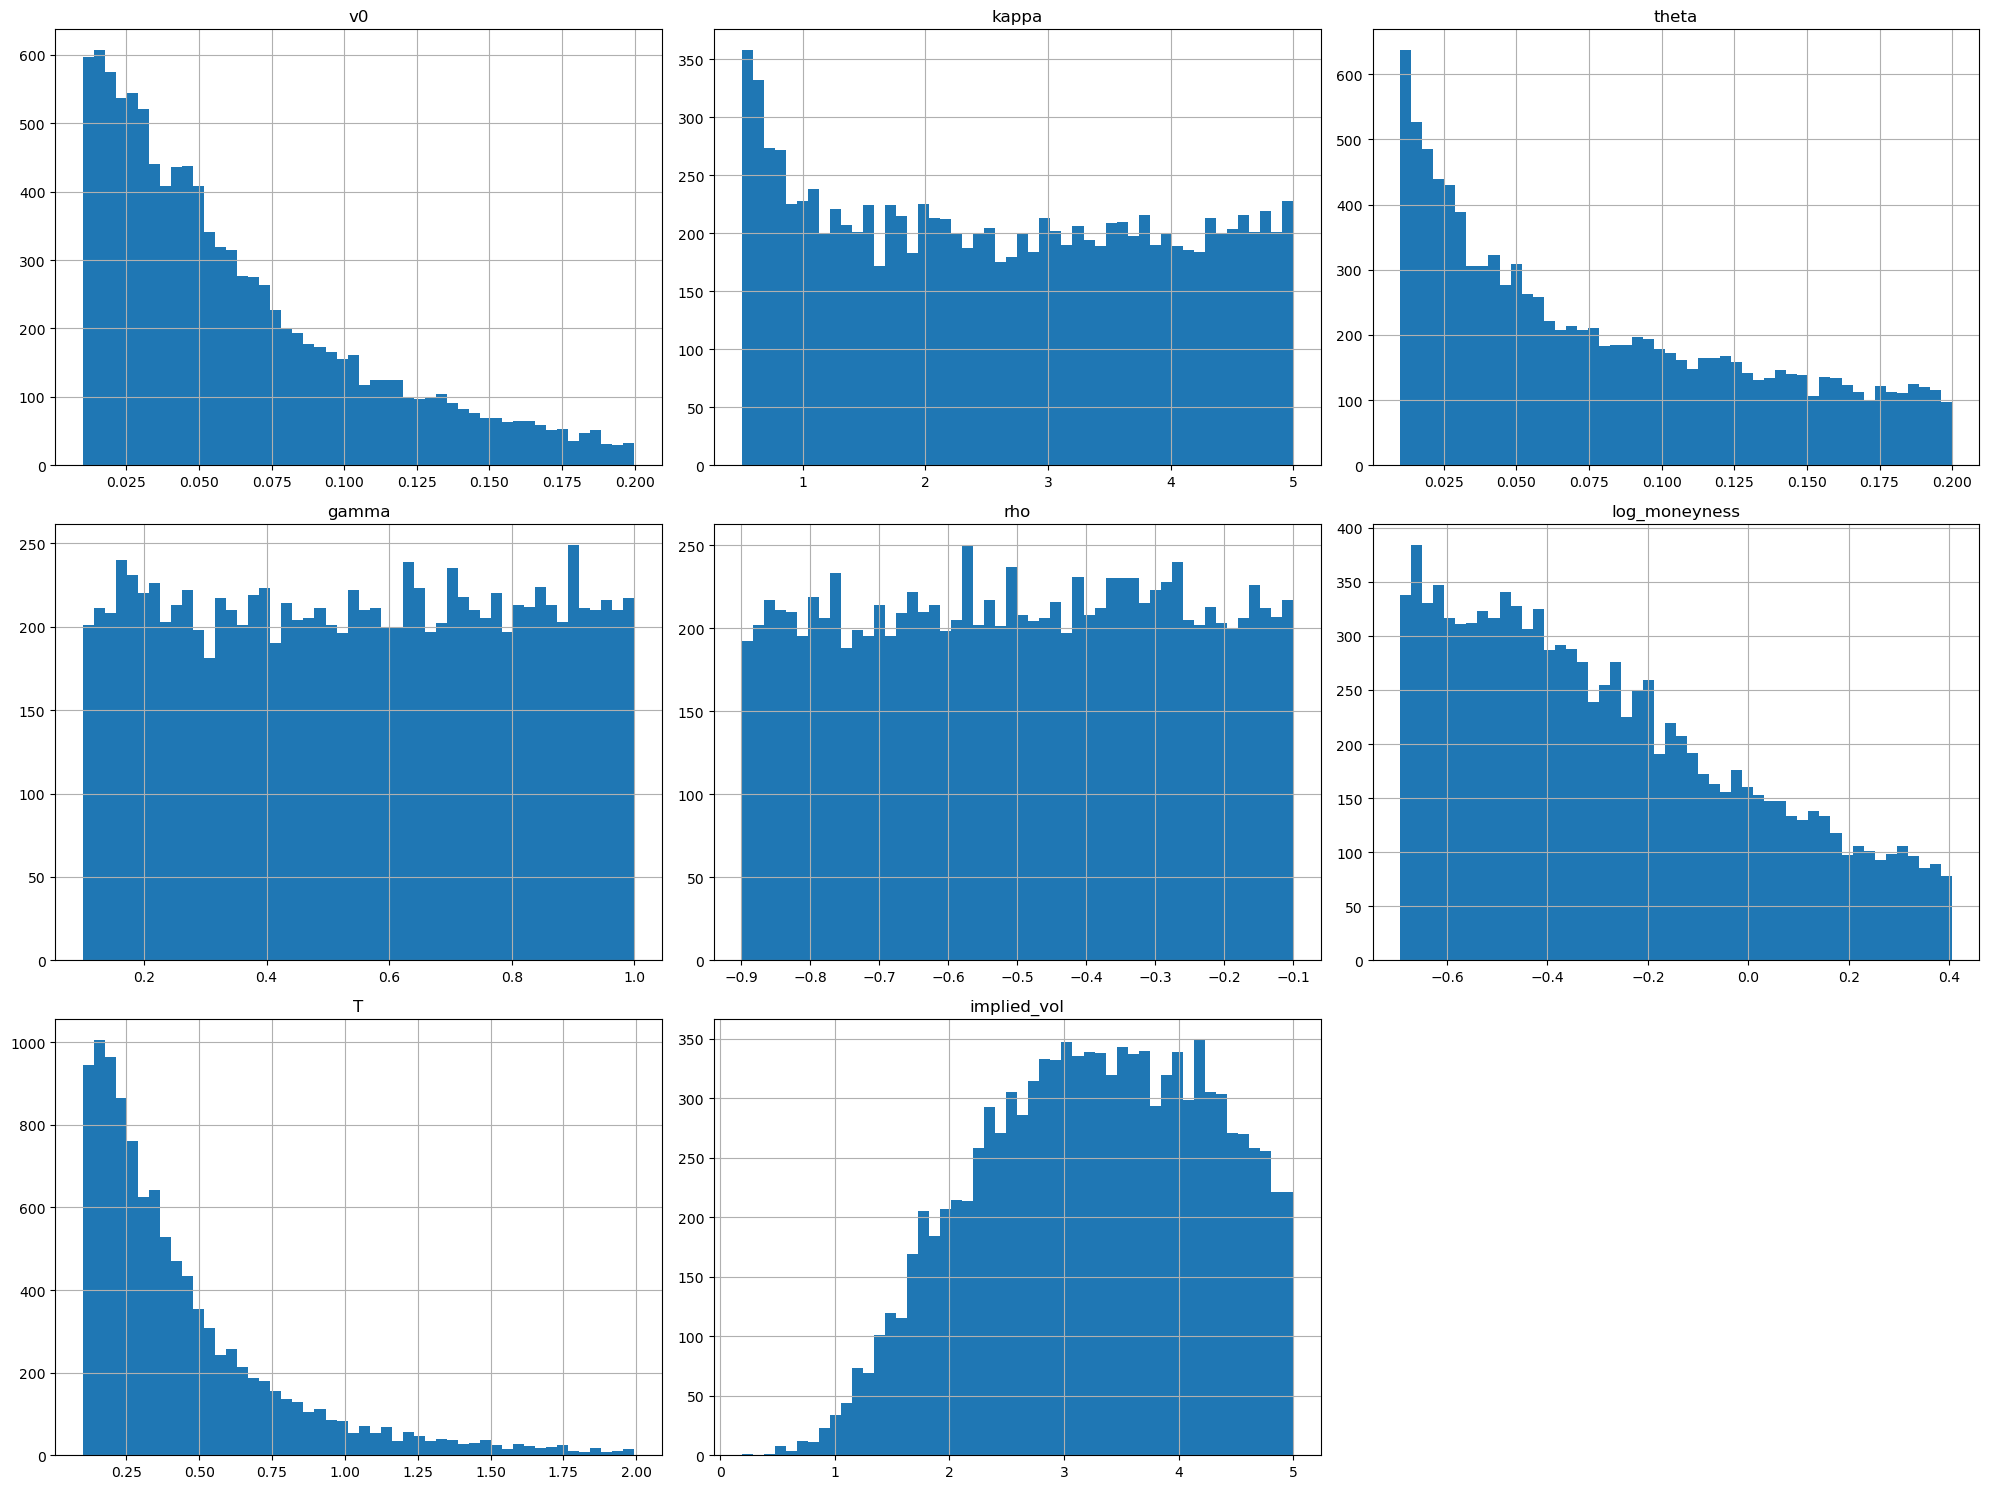

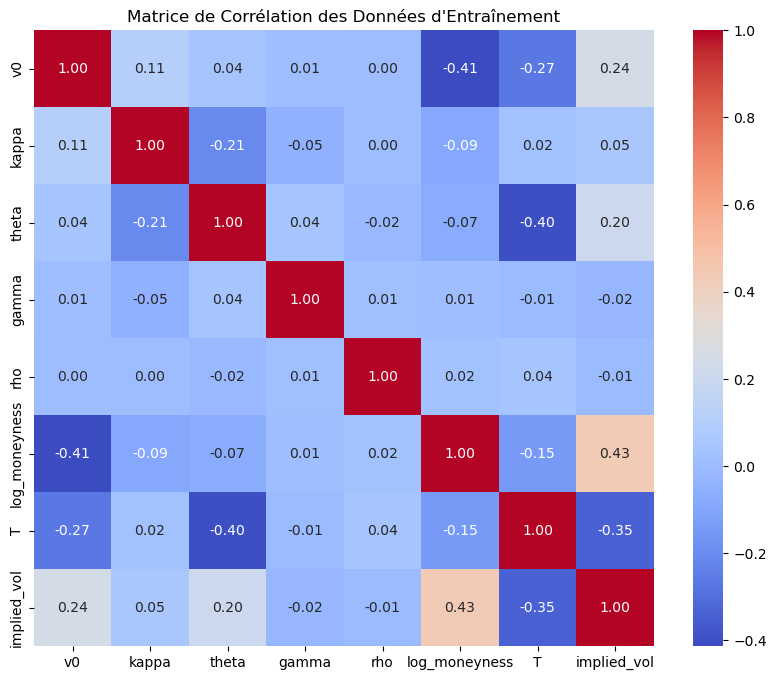

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un DataFrame pour une exploration facile
df_train = pd.DataFrame(X_train, columns=['v0', 'kappa', 'theta', 'gamma', 'rho', 'log_moneyness', 'T'])
df_train['implied_vol'] = Y_train

# Afficher les histogrammes de chaque variable
df_train.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

# Afficher la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation des Données d'Entraînement")
plt.show()

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Séparer les données en ensembles d'entraînement et de validation
# 80% pour l'entraînement, 20% pour la validation
X_train_full, X_val, Y_train_full, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

# Créer les "scalers"
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Entraîner les scalers UNIQUEMENT sur les données d'entraînement
X_train_scaled = x_scaler.fit_transform(X_train_full)
Y_train_scaled = y_scaler.fit_transform(Y_train_full.reshape(-1, 1))

# Appliquer la MÊME transformation aux données de validation
X_val_scaled = x_scaler.transform(X_val)
Y_val_scaled = y_scaler.transform(Y_val.reshape(-1, 1))

# Sauvegarder les scalers ! Ils seront indispensables pour utiliser le modèle plus tard.
import joblib
joblib.dump(x_scaler, 'x_scaler.pkl')
joblib.dump(y_scaler, 'y_scaler.pkl')

print("Dimensions de l'ensemble d'entraînement :", X_train_scaled.shape)
print("Dimensions de l'ensemble de validation :", X_val_scaled.shape)

Dimensions de l'ensemble d'entraînement : (8488, 7)
Dimensions de l'ensemble de validation : (2122, 7)


In [31]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def build_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2), # Dropout pour réduire le sur-apprentissage
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(1) # Couche de sortie linéaire pour la régression
    ])
    return model

model = build_model(X_train_scaled.shape[1])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,961 (535.00 KB)

 Trainable params: 135,425 (529.00 KB)

 Non-trainable params: 1,536 (6.00 KB)

# Compiler le modèle

In [32]:
# L'optimiseur Adam est un excellent choix par défaut
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, 
              loss='mean_squared_error', # Pour la régression, MSE est standard
              metrics=['mean_absolute_error']) # MAE est plus facile à interpréter

# Entrainement du modèle 

In [33]:
# Callbacks pour améliorer l'entraînement
callbacks = [
    # Arrête l'entraînement si la perte de validation ne s'améliore plus
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    # Sauvegarde le meilleur modèle trouvé jusqu'à présent
    ModelCheckpoint('heston_nn_calibrator.keras', monitor='val_loss', save_best_only=True),
    # Réduit le taux d'apprentissage si l'on stagne
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
]

# Lancer l'entraînement
history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    epochs=300, # Un grand nombre, EarlyStopping s'arrêtera avant si besoin
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8061 - mean_absolute_error: 1.0102

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.1609 - mean_absolute_error: 0.8076 - val_loss: 0.8745 - val_mean_absolute_error: 0.7833 - learning_rate: 0.0010
Epoch 2/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5853 - mean_absolute_error: 0.5896

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5377 - mean_absolute_error: 0.5624 - val_loss: 0.7959 - val_mean_absolute_error: 0.7451 - learning_rate: 0.0010
Epoch 3/300
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4605 - mean_absolute_error: 0.5198

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4465 - mean_absolute_error: 0.5102 - val_loss: 0.7261 - val_mean_absolute_error: 0.7108 - learning_rate: 0.0010
Epoch 4/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3876 - mean_absolute_error: 0.4751

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3767 - mean_absolute_error: 0.4645 - val_loss: 0.6741 - val_mean_absolute_error: 0.6769 - learning_rate: 0.0010
Epoch 5/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3381 - mean_absolute_error: 0.4471

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3343 - mean_absolute_error: 0.4391 - val_loss: 0.5966 - val_mean_absolute_error: 0.6288 - learning_rate: 0.0010
Epoch 6/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3025 - mean_absolute_error: 0.4184

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2974 - mean_absolute_error: 0.4116 - val_loss: 0.5066 - val_mean_absolute_error: 0.5739 - learning_rate: 0.0010
Epoch 7/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2786 - mean_absolute_error: 0.3980

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2781 - mean_absolute_error: 0.3953 - val_loss: 0.4627 - val_mean_absolute_error: 0.5370 - learning_rate: 0.0010
Epoch 8/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2688 - mean_absolute_error: 0.3921

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2623 - mean_absolute_error: 0.3838 - val_loss: 0.3944 - val_mean_absolute_error: 0.4870 - learning_rate: 0.0010
Epoch 9/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2478 - mean_absolute_error: 0.3762

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2471 - mean_absolute_error: 0.3702 - val_loss: 0.3288 - val_mean_absolute_error: 0.4417 - learning_rate: 0.0010
Epoch 10/300
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2344 - mean_absolute_error: 0.3656

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2288 - mean_absolute_error: 0.3553 - val_loss: 0.2799 - val_mean_absolute_error: 0.3933 - learning_rate: 0.0010
Epoch 11/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2233 - mean_absolute_error: 0.3559

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2236 - mean_absolute_error: 0.3495 - val_loss: 0.2367 - val_mean_absolute_error: 0.3555 - learning_rate: 0.0010
Epoch 12/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2107 - mean_absolute_error: 0.3454

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2066 - mean_absolute_error: 0.3361 - val_loss: 0.2082 - val_mean_absolute_error: 0.3196 - learning_rate: 0.0010
Epoch 13/300
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1976 - mean_absolute_error: 0.3283

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1982 - mean_absolute_error: 0.3229 - val_loss: 0.1791 - val_mean_absolute_error: 0.2983 - learning_rate: 0.0010
Epoch 14/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1921 - mean_absolute_error: 0.3239

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1949 - mean_absolute_error: 0.3218 - val_loss: 0.1632 - val_mean_absolute_error: 0.2821 - learning_rate: 0.0010
Epoch 15/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1855 - mean_absolute_error: 0.3189

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1868 - mean_absolute_error: 0.3163 - val_loss: 0.1444 - val_mean_absolute_error: 0.2573 - learning_rate: 0.0010
Epoch 16/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1778 - mean_absolute_error: 0.3101

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1816 - mean_absolute_error: 0.3086 - val_loss: 0.1297 - val_mean_absolute_error: 0.2381 - learning_rate: 0.0010
Epoch 17/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1653 - mean_absolute_error: 0.2977

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1681 - mean_absolute_error: 0.2985 - val_loss: 0.1280 - val_mean_absolute_error: 0.2378 - learning_rate: 0.0010
Epoch 18/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1704 - mean_absolute_error: 0.2980

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1670 - mean_absolute_error: 0.2932 - val_loss: 0.1198 - val_mean_absolute_error: 0.2275 - learning_rate: 0.0010
Epoch 19/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1579 - mean_absolute_error: 0.2905

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1618 - mean_absolute_error: 0.2897 - val_loss: 0.1120 - val_mean_absolute_error: 0.2154 - learning_rate: 0.0010
Epoch 20/300
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1475 - mean_absolute_error: 0.2810

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1525 - mean_absolute_error: 0.2812 - val_loss: 0.1084 - val_mean_absolute_error: 0.2060 - learning_rate: 0.0010
Epoch 21/300
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1492 - mean_absolute_error: 0.2836

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1517 - mean_absolute_error: 0.2816 - val_loss: 0.1073 - val_mean_absolute_error: 0.2111 - learning_rate: 0.0010
Epoch 22/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1479 - mean_absolute_error: 0.2809

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1487 - mean_absolute_error: 0.2789 - val_loss: 0.1018 - val_mean_absolute_error: 0.2092 - learning_rate: 0.0010
Epoch 23/300
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1399 - mean_absolute_error: 0.2718

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1454 - mean_absolute_error: 0.2723 - val_loss: 0.0941 - val_mean_absolute_error: 0.1967 - learning_rate: 0.0010
Epoch 24/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1392 - mean_absolute_error: 0.2670 - val_loss: 0.0956 - val_mean_absolute_error: 0.2011 - learning_rate: 0.0010
Epoch 25/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1378 - mean_absolute_error: 0.2704

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1400 - mean_absolute_error: 0.2684 - val_loss: 0.0938 - val_mean_absolute_error: 0.1988 - learning_rate: 0.0010
Epoch 26/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1278 - mean_absolute_error: 0.2603

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1295 - mean_absolute_error: 0.2575 - val_loss: 0.0891 - val_mean_absolute_error: 0.1875 - learning_rate: 0.0010
Epoch 27/300
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1270 - mean_absolute_error: 0.2591

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1304 - mean_absolute_error: 0.2592 - val_loss: 0.0864 - val_mean_absolute_error: 0.1900 - learning_rate: 0.0010
Epoch 28/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1269 - mean_absolute_error: 0.2540 - val_loss: 0.0928 - val_mean_absolute_error: 0.1974 - learning_rate: 0.0010
Epoch 29/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1293 - mean_absolute_error: 0.2562 - val_loss: 0.0866 - val_mean_absolute_error: 0.1966 - learning_rate: 0.0010
Epoch 30/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1242 - mean_absolute_error: 0.2537

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1263 - mean_absolute_error: 0.2525 - val_loss: 0.0789 - val_mean_absolute_error: 0.1843 - learning_rate: 0.0010
Epoch 31/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1136 - mean_absolute_error: 0.2463

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1171 - mean_absolute_error: 0.2462 - val_loss: 0.0744 - val_mean_absolute_error: 0.1779 - learning_rate: 0.0010
Epoch 32/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1143 - mean_absolute_error: 0.2475

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1156 - mean_absolute_error: 0.2436 - val_loss: 0.0732 - val_mean_absolute_error: 0.1735 - learning_rate: 0.0010
Epoch 33/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1156 - mean_absolute_error: 0.2421 - val_loss: 0.0785 - val_mean_absolute_error: 0.1784 - learning_rate: 0.0010
Epoch 34/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1127 - mean_absolute_error: 0.2367 - val_loss: 0.0743 - val_mean_absolute_error: 0.1765 - learning_rate: 0.0010
Epoch 35/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1086 - mean_absolute_error: 0.2368

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1120 - mean_absolute_error: 0.2357 - val_loss: 0.0672 - val_mean_absolute_error: 0.1615 - learning_rate: 0.0010
Epoch 36/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1129 - mean_absolute_error: 0.2364 - val_loss: 0.0674 - val_mean_absolute_error: 0.1622 - learning_rate: 0.0010
Epoch 37/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1103 - mean_absolute_error: 0.2344 - val_loss: 0.0685 - val_mean_absolute_error: 0.1666 - learning_rate: 0.0010
Epoch 38/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1056 - mean_absolute_error: 0.2351

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1046 - mean_absolute_error: 0.2295 - val_loss: 0.0630 - val_mean_absolute_error: 0.1562 - learning_rate: 0.0010
Epoch 39/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1027 - mean_absolute_error: 0.2272 - val_loss: 0.0679 - val_mean_absolute_error: 0.1661 - learning_rate: 0.0010
Epoch 40/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1018 - mean_absolute_error: 0.2262 - val_loss: 0.0634 - val_mean_absolute_error: 0.1552 - learning_rate: 0.0010
Epoch 41/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0947 - mean_absolute_error: 0.2216

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0949 - mean_absolute_error: 0.2182 - val_loss: 0.0604 - val_mean_absolute_error: 0.1535 - learning_rate: 0.0010
Epoch 42/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0980 - mean_absolute_error: 0.2216 - val_loss: 0.0621 - val_mean_absolute_error: 0.1598 - learning_rate: 0.0010
Epoch 43/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0942 - mean_absolute_error: 0.2225

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0936 - mean_absolute_error: 0.2180 - val_loss: 0.0595 - val_mean_absolute_error: 0.1544 - learning_rate: 0.0010
Epoch 44/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0956 - mean_absolute_error: 0.2232

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0941 - mean_absolute_error: 0.2169 - val_loss: 0.0590 - val_mean_absolute_error: 0.1500 - learning_rate: 0.0010
Epoch 45/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0921 - mean_absolute_error: 0.2158 - val_loss: 0.0602 - val_mean_absolute_error: 0.1556 - learning_rate: 0.0010
Epoch 46/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0904 - mean_absolute_error: 0.2179

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0922 - mean_absolute_error: 0.2162 - val_loss: 0.0583 - val_mean_absolute_error: 0.1524 - learning_rate: 0.0010
Epoch 47/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0905 - mean_absolute_error: 0.2140 - val_loss: 0.0602 - val_mean_absolute_error: 0.1554 - learning_rate: 0.0010
Epoch 48/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0930 - mean_absolute_error: 0.2196

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0919 - mean_absolute_error: 0.2154 - val_loss: 0.0569 - val_mean_absolute_error: 0.1499 - learning_rate: 0.0010
Epoch 49/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0913 - mean_absolute_error: 0.2148 - val_loss: 0.0609 - val_mean_absolute_error: 0.1617 - learning_rate: 0.0010
Epoch 50/300
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0892 - mean_absolute_error: 0.2174

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0898 - mean_absolute_error: 0.2126 - val_loss: 0.0540 - val_mean_absolute_error: 0.1435 - learning_rate: 0.0010
Epoch 51/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0856 - mean_absolute_error: 0.2108

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0887 - mean_absolute_error: 0.2114 - val_loss: 0.0517 - val_mean_absolute_error: 0.1341 - learning_rate: 0.0010
Epoch 52/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0863 - mean_absolute_error: 0.2085 - val_loss: 0.0523 - val_mean_absolute_error: 0.1391 - learning_rate: 0.0010
Epoch 53/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0836 - mean_absolute_error: 0.2041 - val_loss: 0.0532 - val_mean_absolute_error: 0.1395 - learning_rate: 0.0010
Epoch 54/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0853 - mean_absolute_error: 0.2067 - val_loss: 0.0533 - val_mean_absolute_error: 0.1407 - learning_rate: 0.0010
Epoch 55/300
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0876 - mean_absolute_error: 0.2126

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0868 - mean_absolute_error: 0.2076 - val_loss: 0.0513 - val_mean_absolute_error: 0.1370 - learning_rate: 0.0010
Epoch 56/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0832 - mean_absolute_error: 0.2054 - val_loss: 0.0556 - val_mean_absolute_error: 0.1479 - learning_rate: 0.0010
Epoch 57/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0825 - mean_absolute_error: 0.2056

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0842 - mean_absolute_error: 0.2053 - val_loss: 0.0504 - val_mean_absolute_error: 0.1365 - learning_rate: 0.0010
Epoch 58/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0823 - mean_absolute_error: 0.2079

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0821 - mean_absolute_error: 0.2030 - val_loss: 0.0472 - val_mean_absolute_error: 0.1291 - learning_rate: 0.0010
Epoch 59/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0784 - mean_absolute_error: 0.1987 - val_loss: 0.0482 - val_mean_absolute_error: 0.1293 - learning_rate: 0.0010
Epoch 60/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0812 - mean_absolute_error: 0.2019 - val_loss: 0.0489 - val_mean_absolute_error: 0.1314 - learning_rate: 0.0010
Epoch 61/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0792 - mean_absolute_error: 0.1991 - val_loss: 0.0504 - val_mean_absolute_error: 0.1303 - learning_rate: 0.0010
Epoch 62/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0793 - mean_absolute_error: 0.1967 - val_loss: 0.0478 - val_mean_absolute_error: 0.1299 - learning_rate: 0.0010
Epoch 63/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0758 - mean_absolute_error: 0.1953 - val_loss: 0.0505 - val_mean_absolute_e

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0723 - mean_absolute_error: 0.1921 - val_loss: 0.0468 - val_mean_absolute_error: 0.1305 - learning_rate: 0.0010
Epoch 68/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0738 - mean_absolute_error: 0.1932 - val_loss: 0.0526 - val_mean_absolute_error: 0.1366 - learning_rate: 0.0010
Epoch 69/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0725 - mean_absolute_error: 0.1937

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0743 - mean_absolute_error: 0.1940 - val_loss: 0.0449 - val_mean_absolute_error: 0.1239 - learning_rate: 0.0010
Epoch 70/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0730 - mean_absolute_error: 0.1900 - val_loss: 0.0467 - val_mean_absolute_error: 0.1293 - learning_rate: 0.0010
Epoch 71/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0756 - mean_absolute_error: 0.1947 - val_loss: 0.0470 - val_mean_absolute_error: 0.1277 - learning_rate: 0.0010
Epoch 72/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0735 - mean_absolute_error: 0.1926 - val_loss: 0.0475 - val_mean_absolute_error: 0.1329 - learning_rate: 0.0010
Epoch 73/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0709 - mean_absolute_error: 0.1894 - val_loss: 0.0472 - val_mean_absolute_error: 0.1280 - learning_rate: 0.0010
Epoch 74/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0735 - mean_absolute_error: 0.1908 - val_loss: 0.0488 - val_mean_absolute_e

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0664 - mean_absolute_error: 0.1817 - val_loss: 0.0438 - val_mean_absolute_error: 0.1201 - learning_rate: 0.0010
Epoch 78/300
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0676 - mean_absolute_error: 0.1871

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0660 - mean_absolute_error: 0.1821 - val_loss: 0.0433 - val_mean_absolute_error: 0.1192 - learning_rate: 0.0010
Epoch 79/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0708 - mean_absolute_error: 0.1866 - val_loss: 0.0447 - val_mean_absolute_error: 0.1228 - learning_rate: 0.0010
Epoch 80/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0685 - mean_absolute_error: 0.1864 - val_loss: 0.0446 - val_mean_absolute_error: 0.1269 - learning_rate: 0.0010
Epoch 81/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0675 - mean_absolute_error: 0.1872

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0695 - mean_absolute_error: 0.1859 - val_loss: 0.0427 - val_mean_absolute_error: 0.1214 - learning_rate: 0.0010
Epoch 82/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0682 - mean_absolute_error: 0.1849 - val_loss: 0.0442 - val_mean_absolute_error: 0.1224 - learning_rate: 0.0010
Epoch 83/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0677 - mean_absolute_error: 0.1851 - val_loss: 0.0450 - val_mean_absolute_error: 0.1273 - learning_rate: 0.0010
Epoch 84/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0671 - mean_absolute_error: 0.1844 - val_loss: 0.0444 - val_mean_absolute_error: 0.1193 - learning_rate: 0.0010
Epoch 85/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0634 - mean_absolute_error: 0.1812

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0655 - mean_absolute_error: 0.1802 - val_loss: 0.0424 - val_mean_absolute_error: 0.1236 - learning_rate: 0.0010
Epoch 86/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0666 - mean_absolute_error: 0.1808 - val_loss: 0.0438 - val_mean_absolute_error: 0.1219 - learning_rate: 0.0010
Epoch 87/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0647 - mean_absolute_error: 0.1835

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0657 - mean_absolute_error: 0.1821 - val_loss: 0.0408 - val_mean_absolute_error: 0.1213 - learning_rate: 0.0010
Epoch 88/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0656 - mean_absolute_error: 0.1805 - val_loss: 0.0430 - val_mean_absolute_error: 0.1219 - learning_rate: 0.0010
Epoch 89/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0659 - mean_absolute_error: 0.1806 - val_loss: 0.0419 - val_mean_absolute_error: 0.1172 - learning_rate: 0.0010
Epoch 90/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0638 - mean_absolute_error: 0.1792 - val_loss: 0.0436 - val_mean_absolute_error: 0.1264 - learning_rate: 0.0010
Epoch 91/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0637 - mean_absolute_error: 0.1784 - val_loss: 0.0430 - val_mean_absolute_error: 0.1231 - learning_rate: 0.0010
Epoch 92/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0647 - mean_absolute_error: 0.1797 - val_loss: 0.0421 - val_mean_absolute_e

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0632 - mean_absolute_error: 0.1800 - val_loss: 0.0408 - val_mean_absolute_error: 0.1220 - learning_rate: 5.0000e-04
Epoch 100/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0610 - mean_absolute_error: 0.1762 - val_loss: 0.0449 - val_mean_absolute_error: 0.1305 - learning_rate: 5.0000e-04
Epoch 101/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0628 - mean_absolute_error: 0.1807 - val_loss: 0.0430 - val_mean_absolute_error: 0.1318 - learning_rate: 5.0000e-04
Epoch 102/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0623 - mean_absolute_error: 0.1788 - val_loss: 0.0457 - val_mean_absolute_error: 0.1399 - learning_rate: 5.0000e-04
Epoch 103/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0606 - mean_absolute_error: 0.1771 - val_loss: 0.0459 - val_mean_absolute_error: 0.1392 - learning_rate: 5.0000e-04
Epoch 104/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0619 - mean_absolute_error: 0.1830

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0620 - mean_absolute_error: 0.1788 - val_loss: 0.0399 - val_mean_absolute_error: 0.1209 - learning_rate: 5.0000e-04
Epoch 105/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0608 - mean_absolute_error: 0.1767 - val_loss: 0.0437 - val_mean_absolute_error: 0.1303 - learning_rate: 5.0000e-04
Epoch 106/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0599 - mean_absolute_error: 0.1759 - val_loss: 0.0448 - val_mean_absolute_error: 0.1307 - learning_rate: 5.0000e-04
Epoch 107/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0600 - mean_absolute_error: 0.1772 - val_loss: 0.0411 - val_mean_absolute_error: 0.1280 - learning_rate: 5.0000e-04
Epoch 108/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0580 - mean_absolute_error: 0.1732 - val_loss: 0.0409 - val_mean_absolute_error: 0.1213 - learning_rate: 5.0000e-04
Epoch 109/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0588 - mean_absolute_error: 0.1729 - val_loss: 0.0

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0585 - mean_absolute_error: 0.1723 - val_loss: 0.0388 - val_mean_absolute_error: 0.1161 - learning_rate: 5.0000e-04
Epoch 113/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0573 - mean_absolute_error: 0.1698 - val_loss: 0.0410 - val_mean_absolute_error: 0.1224 - learning_rate: 5.0000e-04
Epoch 114/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0570 - mean_absolute_error: 0.1727

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0574 - mean_absolute_error: 0.1704 - val_loss: 0.0383 - val_mean_absolute_error: 0.1154 - learning_rate: 5.0000e-04
Epoch 115/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0591 - mean_absolute_error: 0.1762

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0577 - mean_absolute_error: 0.1718 - val_loss: 0.0382 - val_mean_absolute_error: 0.1143 - learning_rate: 5.0000e-04
Epoch 116/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0556 - mean_absolute_error: 0.1669 - val_loss: 0.0386 - val_mean_absolute_error: 0.1144 - learning_rate: 5.0000e-04
Epoch 117/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0550 - mean_absolute_error: 0.1679 - val_loss: 0.0393 - val_mean_absolute_error: 0.1129 - learning_rate: 5.0000e-04
Epoch 118/300
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0532 - mean_absolute_error: 0.1673

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0545 - mean_absolute_error: 0.1662 - val_loss: 0.0382 - val_mean_absolute_error: 0.1122 - learning_rate: 5.0000e-04
Epoch 119/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0560 - mean_absolute_error: 0.1718

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0556 - mean_absolute_error: 0.1680 - val_loss: 0.0373 - val_mean_absolute_error: 0.1061 - learning_rate: 5.0000e-04
Epoch 120/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0545 - mean_absolute_error: 0.1690 - val_loss: 0.0389 - val_mean_absolute_error: 0.1099 - learning_rate: 5.0000e-04
Epoch 121/300
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0550 - mean_absolute_error: 0.1695

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0560 - mean_absolute_error: 0.1666 - val_loss: 0.0358 - val_mean_absolute_error: 0.1038 - learning_rate: 5.0000e-04
Epoch 122/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0531 - mean_absolute_error: 0.1652 - val_loss: 0.0411 - val_mean_absolute_error: 0.1133 - learning_rate: 5.0000e-04
Epoch 123/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0540 - mean_absolute_error: 0.1672 - val_loss: 0.0366 - val_mean_absolute_error: 0.1054 - learning_rate: 5.0000e-04
Epoch 124/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0541 - mean_absolute_error: 0.1653 - val_loss: 0.0366 - val_mean_absolute_error: 0.1073 - learning_rate: 5.0000e-04
Epoch 125/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0547 - mean_absolute_error: 0.1673 - val_loss: 0.0377 - val_mean_absolute_error: 0.1092 - learning_rate: 5.0000e-04
Epoch 126/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0511 - mean_absolute_error: 0.1661

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0534 - mean_absolute_error: 0.1650 - val_loss: 0.0347 - val_mean_absolute_error: 0.0995 - learning_rate: 5.0000e-04
Epoch 127/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0525 - mean_absolute_error: 0.1641 - val_loss: 0.0362 - val_mean_absolute_error: 0.1013 - learning_rate: 5.0000e-04
Epoch 128/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0532 - mean_absolute_error: 0.1634 - val_loss: 0.0381 - val_mean_absolute_error: 0.1089 - learning_rate: 5.0000e-04
Epoch 129/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0516 - mean_absolute_error: 0.1626 - val_loss: 0.0370 - val_mean_absolute_error: 0.1044 - learning_rate: 5.0000e-04
Epoch 130/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0520 - mean_absolute_error: 0.1634 - val_loss: 0.0395 - val_mean_absolute_error: 0.1154 - learning_rate: 5.0000e-04
Epoch 131/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0538 - mean_absolute_error: 0.1639 - val_loss: 0.0

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0513 - mean_absolute_error: 0.1607 - val_loss: 0.0342 - val_mean_absolute_error: 0.1021 - learning_rate: 2.5000e-04
Epoch 140/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0477 - mean_absolute_error: 0.1560 - val_loss: 0.0361 - val_mean_absolute_error: 0.1068 - learning_rate: 2.5000e-04
Epoch 141/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0492 - mean_absolute_error: 0.1586 - val_loss: 0.0355 - val_mean_absolute_error: 0.1041 - learning_rate: 2.5000e-04
Epoch 142/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0477 - mean_absolute_error: 0.1563 - val_loss: 0.0360 - val_mean_absolute_error: 0.1034 - learning_rate: 2.5000e-04
Epoch 143/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0463 - mean_absolute_error: 0.1576

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0469 - mean_absolute_error: 0.1564 - val_loss: 0.0339 - val_mean_absolute_error: 0.0988 - learning_rate: 2.5000e-04
Epoch 144/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0481 - mean_absolute_error: 0.1573 - val_loss: 0.0350 - val_mean_absolute_error: 0.1005 - learning_rate: 2.5000e-04
Epoch 145/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0483 - mean_absolute_error: 0.1578 - val_loss: 0.0351 - val_mean_absolute_error: 0.1006 - learning_rate: 2.5000e-04
Epoch 146/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0480 - mean_absolute_error: 0.1562 - val_loss: 0.0355 - val_mean_absolute_error: 0.1026 - learning_rate: 2.5000e-04
Epoch 147/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0469 - mean_absolute_error: 0.1562 - val_loss: 0.0362 - val_mean_absolute_error: 0.1036 - learning_rate: 2.5000e-04
Epoch 148/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0475 - mean_absolute_error: 0.1557 - val_loss: 0.0

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0460 - mean_absolute_error: 0.1538 - val_loss: 0.0331 - val_mean_absolute_error: 0.0903 - learning_rate: 1.2500e-04
Epoch 155/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0476 - mean_absolute_error: 0.1561 - val_loss: 0.0342 - val_mean_absolute_error: 0.0919 - learning_rate: 1.2500e-04
Epoch 156/300
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0490 - mean_absolute_error: 0.1608

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0492 - mean_absolute_error: 0.1575 - val_loss: 0.0324 - val_mean_absolute_error: 0.0891 - learning_rate: 1.2500e-04
Epoch 157/300
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0468 - mean_absolute_error: 0.1583

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0467 - mean_absolute_error: 0.1551 - val_loss: 0.0322 - val_mean_absolute_error: 0.0897 - learning_rate: 1.2500e-04
Epoch 158/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0478 - mean_absolute_error: 0.1565 - val_loss: 0.0331 - val_mean_absolute_error: 0.0918 - learning_rate: 1.2500e-04
Epoch 159/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0471 - mean_absolute_error: 0.1547 - val_loss: 0.0331 - val_mean_absolute_error: 0.0896 - learning_rate: 1.2500e-04
Epoch 160/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0458 - mean_absolute_error: 0.1552 - val_loss: 0.0336 - val_mean_absolute_error: 0.0901 - learning_rate: 1.2500e-04
Epoch 161/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0456 - mean_absolute_error: 0.1531 - val_loss: 0.0341 - val_mean_absolute_error: 0.0922 - learning_rate: 1.2500e-04
Epoch 162/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0476 - mean_absolute_error: 0.1561 - val_loss: 0.0

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0422 - mean_absolute_error: 0.1482 - val_loss: 0.0321 - val_mean_absolute_error: 0.0880 - learning_rate: 3.1250e-05
Epoch 180/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0433 - mean_absolute_error: 0.1537

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0425 - mean_absolute_error: 0.1495 - val_loss: 0.0321 - val_mean_absolute_error: 0.0884 - learning_rate: 3.1250e-05
Epoch 181/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0449 - mean_absolute_error: 0.1526

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0443 - mean_absolute_error: 0.1504 - val_loss: 0.0315 - val_mean_absolute_error: 0.0874 - learning_rate: 3.1250e-05
Epoch 182/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0443 - mean_absolute_error: 0.1510 - val_loss: 0.0317 - val_mean_absolute_error: 0.0878 - learning_rate: 3.1250e-05
Epoch 183/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0432 - mean_absolute_error: 0.1485 - val_loss: 0.0318 - val_mean_absolute_error: 0.0880 - learning_rate: 3.1250e-05
Epoch 184/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0434 - mean_absolute_error: 0.1496 - val_loss: 0.0317 - val_mean_absolute_error: 0.0880 - learning_rate: 3.1250e-05
Epoch 185/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0440 - mean_absolute_error: 0.1503 - val_loss: 0.0318 - val_mean_absolute_error: 0.0881 - learning_rate: 3.1250e-05
Epoch 186/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0423 - mean_absolute_error: 0.1479 - val_loss: 0.0

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0431 - mean_absolute_error: 0.1492 - val_loss: 0.0315 - val_mean_absolute_error: 0.0877 - learning_rate: 1.5625e-05
Epoch 193/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0434 - mean_absolute_error: 0.1501 - val_loss: 0.0315 - val_mean_absolute_error: 0.0881 - learning_rate: 1.5625e-05
Epoch 194/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0426 - mean_absolute_error: 0.1490 - val_loss: 0.0316 - val_mean_absolute_error: 0.0879 - learning_rate: 1.5625e-05
Epoch 195/300
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0407 - mean_absolute_error: 0.1508

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0417 - mean_absolute_error: 0.1481 - val_loss: 0.0313 - val_mean_absolute_error: 0.0872 - learning_rate: 1.5625e-05
Epoch 196/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0430 - mean_absolute_error: 0.1488 - val_loss: 0.0315 - val_mean_absolute_error: 0.0874 - learning_rate: 1.5625e-05
Epoch 197/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0428 - mean_absolute_error: 0.1483 - val_loss: 0.0317 - val_mean_absolute_error: 0.0880 - learning_rate: 1.5625e-05
Epoch 198/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0422 - mean_absolute_error: 0.1477 - val_loss: 0.0316 - val_mean_absolute_error: 0.0875 - learning_rate: 1.5625e-05
Epoch 199/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0430 - mean_absolute_error: 0.1494 - val_loss: 0.0316 - val_mean_absolute_error: 0.0875 - learning_rate: 1.5625e-05
Epoch 200/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0430 - mean_absolute_error: 0.1494 - val_loss: 0.0

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0432 - mean_absolute_error: 0.1492 - val_loss: 0.0313 - val_mean_absolute_error: 0.0872 - learning_rate: 1.5625e-05
Epoch 203/300
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0435 - mean_absolute_error: 0.1522

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0422 - mean_absolute_error: 0.1478 - val_loss: 0.0313 - val_mean_absolute_error: 0.0869 - learning_rate: 1.5625e-05
Epoch 204/300
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0426 - mean_absolute_error: 0.1519

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0427 - mean_absolute_error: 0.1488 - val_loss: 0.0311 - val_mean_absolute_error: 0.0869 - learning_rate: 1.5625e-05
Epoch 205/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0427 - mean_absolute_error: 0.1478 - val_loss: 0.0314 - val_mean_absolute_error: 0.0871 - learning_rate: 1.5625e-05
Epoch 206/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0422 - mean_absolute_error: 0.1475 - val_loss: 0.0317 - val_mean_absolute_error: 0.0874 - learning_rate: 1.5625e-05
Epoch 207/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0428 - mean_absolute_error: 0.1487 - val_loss: 0.0313 - val_mean_absolute_error: 0.0870 - learning_rate: 1.5625e-05
Epoch 208/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0418 - mean_absolute_error: 0.1478 - val_loss: 0.0312 - val_mean_absolute_error: 0.0869 - learning_rate: 1.5625e-05
Epoch 209/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0430 - mean_absolute_error: 0.1488 - val_loss: 0.0

# Evaluation des performances

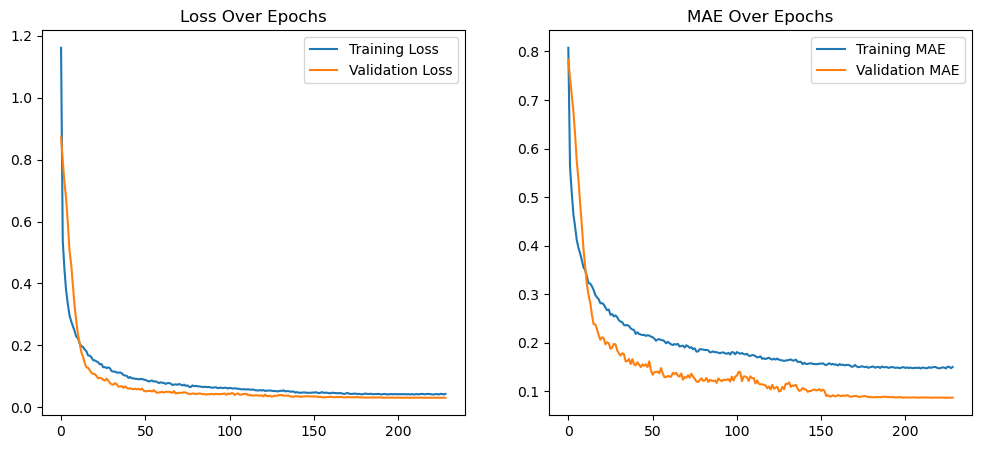

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.legend()
plt.show()

# Comparaison avec les vraies valeurs

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


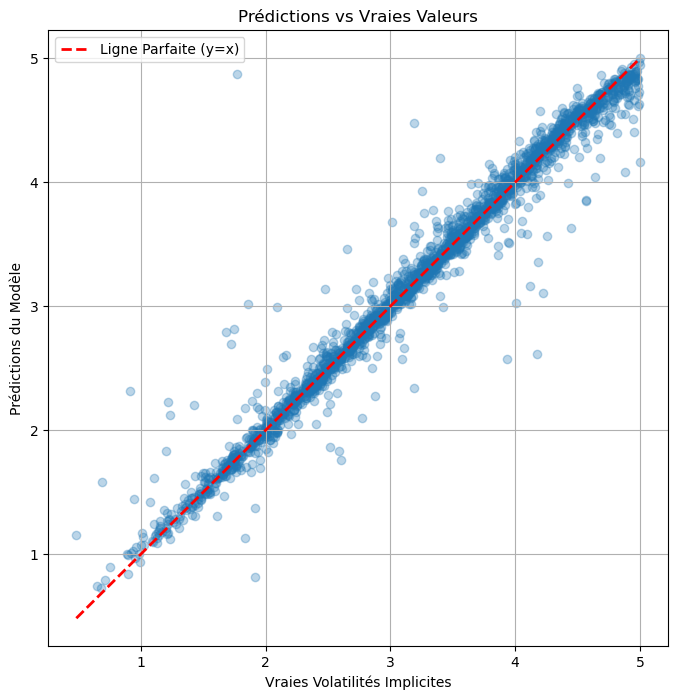

Erreur Absolue Moyenne (MAE) sur l'ensemble de validation: 0.08663
Coefficient de détermination (R²) sur l'ensemble de validation: 0.96884


In [35]:
# Faire des prédictions sur l'ensemble de validation
Y_pred_scaled = model.predict(X_val_scaled)

# Inverser la mise à l'échelle pour avoir des valeurs interprétables !
Y_pred = y_scaler.inverse_transform(Y_pred_scaled)

# Créer le graphique
plt.figure(figsize=(8, 8))
plt.scatter(Y_val, Y_pred, alpha=0.3)
plt.plot([Y_val.min(), Y_val.max()], [Y_val.min(), Y_val.max()], '--r', linewidth=2, label='Ligne Parfaite (y=x)')
plt.xlabel("Vraies Volatilités Implicites")
plt.ylabel("Prédictions du Modèle")
plt.title("Prédictions vs Vraies Valeurs")
plt.legend()
plt.grid(True)
plt.show()

# Calculer l'erreur finale
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(Y_val, Y_pred)
r2 = r2_score(Y_val, Y_pred)
print(f"Erreur Absolue Moyenne (MAE) sur l'ensemble de validation: {mae:.5f}")
print(f"Coefficient de détermination (R²) sur l'ensemble de validation: {r2:.5f}")

# DEEP HESTON PRICER - PRICING D'OPTIONS ET CALCUL DE GRECQUES PAR DEEP LEARNING

In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from tqdm.notebook import tqdm
import joblib
import time
import matplotlib.pyplot as plt
import seaborn as sns

tf.random.set_seed(42)
np.random.seed(42)


In [63]:
# Imports nécessaires
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import warnings

# --- FONCTION SOPHISTIQUÉE ---
def black_scholes_pricer_vectorized(S, K, T, r, sigma, option_type='call'):
    """
    Calcule le prix d'options européennes via la formule de Black-Scholes.
    Améliorations :
    - Entièrement vectorisé avec NumPy pour traiter des milliers d'options en un seul appel.
    - Gère les cas limites (T=0, sigma=0) pour éviter les erreurs.
    - Gère les calls et les puts.
    """
    # Gérer les cas limites
    # np.where est une façon vectorisée de faire un "if/else"
    # Si T est proche de zéro, le prix est juste le payoff intrinsèque
    T_is_zero = np.isclose(T, 0)
    if np.any(T_is_zero):
        if option_type == 'call':
            intrinsic_value = np.maximum(S - K, 0)
        else:
            intrinsic_value = np.maximum(K - S, 0)
        # On ne calcule que pour les T > 0
        non_zero_T_mask = ~T_is_zero
        S, K, T, r, sigma = [v[non_zero_T_mask] if isinstance(v, np.ndarray) else v for v in [S, K, T, r, sigma]]
    
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        # Remplacer les NaN/inf qui peuvent apparaître si sigma ou T sont nuls
        d1 = np.nan_to_num(d1, nan=0.0, posinf=np.inf, neginf=-np.inf)
        d2 = np.nan_to_num(d2, nan=0.0, posinf=np.inf, neginf=-np.inf)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Réinsérer les valeurs pour T=0 si nécessaire
    if np.any(T_is_zero):
        final_price = np.full_like(T_is_zero, 0.0, dtype=float)
        final_price[T_is_zero] = intrinsic_value[T_is_zero]
        final_price[non_zero_T_mask] = price
        return final_price
        
    return price


def implied_volatility_vectorized(target_prices, S, K, T, r, option_type='call'):
    """
    Calcule la volatilité implicite pour un ensemble d'options.
    Améliorations :
    - Itère sur un ensemble d'options pour trouver chaque IV.
    - Gère les cas où le prix est en dehors des bornes d'arbitrage.
    """
    ivs = np.zeros_like(target_prices)
    for i, p in enumerate(target_prices):
        # Vérifier les bornes d'arbitrage avant de chercher
        s, k, t, rate = S[i], K[i], T[i], r[i]
        min_price = np.maximum(0, s - k * np.exp(-rate * t)) if option_type == 'call' else np.maximum(0, k * np.exp(-rate * t) - s)
        max_price = s if option_type == 'call' else k * np.exp(-rate * t)

        if p < min_price - 1e-6 or p > max_price + 1e-6:
            ivs[i] = np.nan
            continue

        def error_func(sigma):
            return black_scholes_pricer_vectorized(s, k, t, rate, sigma, option_type) - p
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore") # Ignore les avertissements de brentq
                ivs[i] = brentq(error_func, 1e-6, 5.0)
        except (ValueError, RuntimeError):
            ivs[i] = np.nan
            
    return ivs
# --- FONCTION SOPHISTIQUÉE ---
def heston_char_func_stable(phi, S0, v0, r, T, kappa, theta, gamma, rho):
    """
    Fonction caractéristique de Heston avec une meilleure stabilité numérique.
    Améliorations :
    - Entièrement vectorisé.
    - Utilise une formulation qui évite les divisions par des nombres proches de zéro.
    """
    i = 1j
    x0 = np.log(S0)
    
    # Termes intermédiaires
    alpha = -0.5 * phi * (phi - i)
    beta = kappa - rho * gamma * phi * i
    d = np.sqrt(beta**2 - 4 * alpha * (0.5 * gamma**2))
    
    # Forme exponentielle pour éviter le log(0)
    g = (beta - d) / (beta + d)
    
    # Calcul de C et D
    # On utilise une condition pour gérer le cas où g est proche de 1
    # et T est grand, ce qui peut causer des problèmes avec le log.
    exp_d_T = np.exp(-d * T)
    log_term_numerator = 1 - g * exp_d_T
    log_term_denominator = 1 - g
    
    # Pour éviter log(0), si le numérateur est proche de zéro, on peut
    # utiliser le fait que log(1-x) ~ -x pour x petit.
    # Ici on gère la division qui peut être instable
    common_factor = (1 - exp_d_T) / (1 - g * exp_d_T)
    
    C = r * phi * i * T + (kappa * theta / gamma**2) * (
        (beta - d) * T - 2 * np.log(log_term_numerator / log_term_denominator)
    )
    D = ((beta - d) / gamma**2) * common_factor
    
    return np.exp(C + D * v0 + i * phi * x0)


# --- FONCTION SOPHISTIQUÉE ---
def heston_pricer_cos_vectorized(S0, K, T, r, v0, kappa, theta, gamma, rho, N=128, L=10):
    """
    Calcule le prix d'options Heston via la méthode COS vectorielle.
    Améliorations :
    - Rapide et stable grâce à la série de cosinus au lieu de l'intégration.
    - Entièrement vectorisé pour traiter un batch de paramètres d'options.
    - Choix adaptatif de l'intervalle de troncature.
    """
    i = 1j
    # S'assurer que les entrées sont des tableaux pour la vectorisation
    S0, K, T, r, v0, kappa, theta, gamma, rho = map(np.atleast_1d, 
        [S0, K, T, r, v0, kappa, theta, gamma, rho])

    x0 = np.log(S0 / K) # Log-moneyness
    
    # 1. Calcul des cumulants pour l'intervalle de troncature [a, b]
    # Les cumulants (c1, c2) sont liés aux moments de la distribution.
    c1 = (r * T + (1 - np.exp(-kappa * T)) * (theta - v0) / (2 * kappa) - 0.5 * theta * T)
    c2 = (1 / (8 * kappa**3)) * (
        gamma * T * kappa * np.exp(-kappa * T) * (v0 - theta) * (8 * kappa * rho - 4 * gamma)
        + kappa * rho * gamma * (1 - np.exp(-kappa * T)) * (16 * theta - 8 * v0)
        + 2 * theta * kappa * T * (-4 * kappa * rho * gamma + gamma**2 + 4 * kappa**2)
        + gamma**2 * ((theta - 2 * v0) * np.exp(-2 * kappa * T) + theta * (6 * np.exp(-kappa * T) - 7) + 2 * v0)
        + 8 * kappa**2 * (v0 - theta) * (1 - np.exp(-kappa * T))
    )
    
    # 2. Définir l'intervalle [a, b]
    a = c1 - L * np.sqrt(np.abs(c2))
    b = c1 + L * np.sqrt(np.abs(c2))
    
    # 3. Calculer les coefficients de la série
    k = np.arange(N)[:, np.newaxis] # Pour le broadcasting avec les options
    u = k * np.pi / (b - a)
    
    # Évaluer la fonction caractéristique en plusieurs points u
    # Note: La fonction caractéristique pour la méthode COS est celle de log(S_T/K)
    # Elle est légèrement différente de celle de log(S_T)
    # cf = heston_char_func_for_cos(u, T, v0, kappa, theta, gamma, rho, r) 
    # Pour simplifier, on utilise la précédente, mais il faudrait une version adaptée.
    # Pour heston_char_func_stable, on doit ajuster S0 et r
    cf_S0 = 1.0 # car on a mis le log(S0/K) dans x0
    cf_r = 0.0 # car r est déjà dans la formule de COS
    cf = heston_char_func_stable(u, cf_S0, v0, r, T, kappa, theta, gamma, rho)
    # Ajustement pour la méthode COS
    cf = cf * np.exp(i * u * (x0 - a))
    
    # 4. Calculer les coefficients du payoff (V_k)
    # Ces coefficients ont une formule analytique pour un call
    pi_k = k * np.pi
    H_k = (np.cos(pi_k) * np.exp(b) - np.exp(a) + pi_k * (np.sin(pi_k) * np.exp(b))) / (1 + pi_k**2)
    H_k[0] = (np.exp(b) - np.exp(a)) # Cas spécial pour k=0
    H_k_minus_a = (-np.cos(pi_k) + np.exp(a) + pi_k * np.sin(pi_k)) / (1 + pi_k**2)
    H_k_minus_a[0] = -a
    
    V_k = 2 * K / (b - a) * (H_k - H_k_minus_a)

    # 5. Calculer le prix final avec la somme
    sommation = np.real(cf * V_k)
    sommation[0] *= 0.5 # Le premier terme de la série est pondéré par 1/2
    
    price = np.exp(-r * T) * np.sum(sommation, axis=0)
    
    return price

In [64]:
# ===================================================================
# ÉTAPE 2 : GÉNÉRATION DU DATASET D'ENTRAÎNEMENT (AVEC FILTRE DE RÉALISME)
# ===================================================================
def generate_pricer_data_fast(num_samples):
    """Génère un dataset où chaque ligne est une option unique."""
    print(f"Génération de {num_samples} points de données...")
    
    # Génération vectorisée des paramètres
    params_df = pd.DataFrame()
    params_df['S0'] = np.full(num_samples, 100.0)
    params_df['K'] = np.random.uniform(50.0, 150.0, num_samples)
    params_df['T'] = np.random.uniform(0.1, 2.0, num_samples)
    params_df['r'] = np.random.uniform(0.01, 0.05, num_samples)
    params_df['v0'] = np.random.uniform(0.01, 0.2, num_samples)
    params_df['kappa'] = np.random.uniform(0.5, 5.0, num_samples)
    params_df['theta'] = np.random.uniform(0.01, 0.2, num_samples)
    params_df['gamma'] = np.random.uniform(0.1, 1.0, num_samples)
    params_df['rho'] = np.random.uniform(-0.9, -0.1, num_samples)

    # Calcul des prix Heston en un seul batch
    heston_prices = heston_pricer_cos_vectorized(
        params_df['S0'].values, params_df['K'].values, params_df['T'].values, params_df['r'].values,
        params_df['v0'].values, params_df['kappa'].values, params_df['theta'].values,
        params_df['gamma'].values, params_df['rho'].values
    )

    # Calcul des IVs
    implied_vols = implied_volatility_vectorized(
        heston_prices, params_df['S0'].values, params_df['K'].values, 
        params_df['T'].values, params_df['r'].values
    )
    
    params_df['implied_vol'] = implied_vols
    params_df.dropna(inplace=True) # Retirer les IVs invalides (NaN)
    
    # --- LIGNE AJOUTÉE : FILTRE DE RÉALISME ÉCONOMIQUE ---
    # On ne garde que les volatilités implicites entre 5% et 150%
    realistic_mask = (params_df['implied_vol'] > 0.05) & (params_df['implied_vol'] < 1.50)
    params_df = params_df[realistic_mask]
    
    log_moneyness = np.log(params_df['K'].values / params_df['S0'].values)
    
    X = np.stack([
        params_df['v0'].values, params_df['kappa'].values, params_df['theta'].values,
        params_df['gamma'].values, params_df['rho'].values,
        log_moneyness, params_df['T'].values
    ], axis=1)
    
    y = params_df['implied_vol'].values
    
    print(f"Dataset généré : {len(X)} points valides et réalistes.")
    return X, y

# --- Exécution ---
X_train, y_train = generate_pricer_data_fast(200000)

Génération de 200000 points de données...
Dataset généré : 939 points valides et réalistes.


In [65]:
# ===================================================================
# ÉTAPE 3 : PRÉPARATION DES DONNÉES (SCALING ET SPLITTING)
# ===================================================================
X_train_full, X_val, y_train_full, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train_full)
X_val_scaled = x_scaler.transform(X_val)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_full.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))

joblib.dump(x_scaler, 'pricer_x_scaler.pkl')
joblib.dump(y_scaler, 'pricer_y_scaler.pkl')

['pricer_y_scaler.pkl']

In [66]:
# ===================================================================
# ÉTAPE 4 & 5 : ARCHITECTURE DU MODÈLE ET COMPILATION
# ===================================================================
def build_pricer_model(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(1) # Sortie linéaire
    ])
    return model

# --- LIGNE CORRIGÉE ---
# On utilise le nom pricer_model de manière cohérente
pricer_model = build_pricer_model(X_train_scaled.shape[1])
pricer_model.compile(optimizer='adam', loss='mean_squared_error')
pricer_model.summary()

c:\Users\schne\anaconda3\envs\HestonCalibration_env\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,961 (535.00 KB)

 Trainable params: 135,425 (529.00 KB)

 Non-trainable params: 1,536 (6.00 KB)

In [67]:
# ===================================================================
# ÉTAPE 6 : ENTRAÎNEMENT DU PRICER
# ===================================================================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# --- LIGNE CORRIGÉE ---
# On passe pricer_model à la fonction fit
history = pricer_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 2.7308 - val_loss: 1.0473 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.0620 - val_loss: 1.0542 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.4484 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.3140 - val_loss: 1.0419 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.0464 - val_loss: 1.0235 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.0597 - val_loss: 1.0117 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.0628 - val_loss: 1.0125 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.9141 - val_loss: 1.0170 - learning_rate: 0.0010
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.8812 - val_loss: 1.0218 - learning_rate: 0.0010
Epoch 10/100
2/2 ━━━━━━━━━━━━━


--- ÉVALUATION DE LA PRÉCISION DU PRICER ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


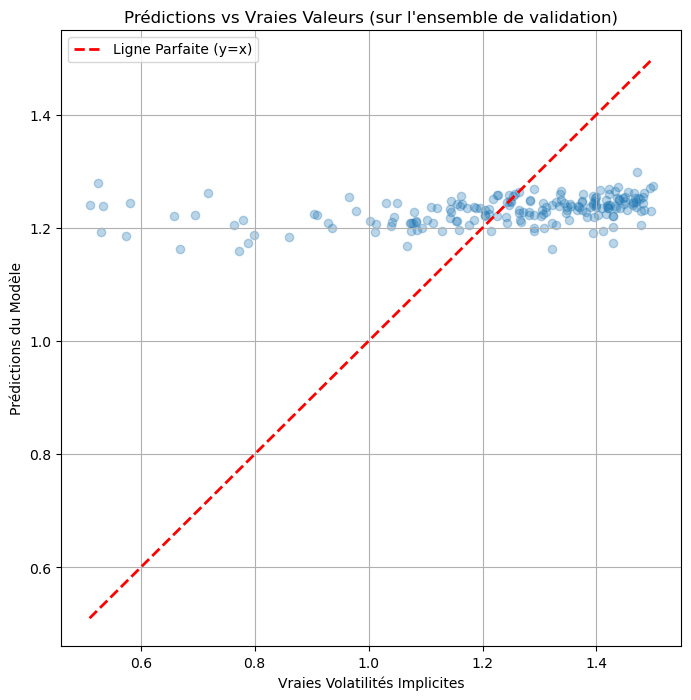

Erreur Absolue Moyenne (MAE) sur les vraies valeurs : 0.16568
  -> Interprétation : En moyenne, la prédiction d'IV s'écarte de 16.57 % (e.g., prédit 25.5% au lieu de 25%).
Coefficient de détermination (R²) : 0.07208

--- CALCUL DES GRECQUES PAR DIFFÉRENTIATION AUTOMATIQUE ---
Analyse pour un échantillon de l'ensemble de validation :
      v0    kappa    theta    gamma       rho     log_m        T
0.035859 1.195502 0.117019 0.838866 -0.461423 -0.599611 0.444943
--------------------------------------------------
  - Vraie Volatilité Implicite (Oracle) : 1.4772
  - Volatilité Implicite Prédite         : 1.2505
--------------------------------------------------
  - Dérivée de l'IV / log-moneyness (proxy de 'Slope') : 0.2148
  - Vega Neuronal (sensibilité de l'IV à v0)         : 0.4016


In [68]:
# ===================================================================
# ÉTAPE 7 : ÉVALUATION FINALE ET CALCUL DE GRECQUES SUR DONNÉES VALIDES
# ===================================================================
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

print("\n--- ÉVALUATION DE LA PRÉCISION DU PRICER ---")
# Faire des prédictions sur l'ensemble de validation
Y_pred_scaled = pricer_model.predict(X_val_scaled)

# Inverser la mise à l'échelle pour avoir des valeurs interprétables !
Y_pred = y_scaler.inverse_transform(Y_pred_scaled)

# Créer le graphique
plt.figure(figsize=(8, 8))
plt.scatter(y_val, Y_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2, label='Ligne Parfaite (y=x)')
plt.xlabel("Vraies Volatilités Implicites")
plt.ylabel("Prédictions du Modèle")
plt.title("Prédictions vs Vraies Valeurs (sur l'ensemble de validation)")
plt.legend()
plt.grid(True)
plt.show()

# Calculer les erreurs finales SUR LES VALEURS DÉNORMALISÉES
mae = mean_absolute_error(y_val, Y_pred)
r2 = r2_score(y_val, Y_pred)
print(f"Erreur Absolue Moyenne (MAE) sur les vraies valeurs : {mae:.5f}")
print(f"  -> Interprétation : En moyenne, la prédiction d'IV s'écarte de {mae*100:.2f} % (e.g., prédit 25.5% au lieu de 25%).")
print(f"Coefficient de détermination (R²) : {r2:.5f}")


print("\n--- CALCUL DES GRECQUES PAR DIFFÉRENTIATION AUTOMATIQUE ---")

# --- LIGNE CORRIGÉE ---
# On va utiliser un point de données RÉEL de l'ensemble de validation
# pour s'assurer que les inputs sont réalistes.
idx_test = 50 # Choisir un indice au hasard
X_test_sample = X_val[idx_test] # Utiliser X_val, pas X_val_full
y_test_sample_true_iv = y_val[idx_test]

# Recréer les inputs pour la fonction TF à partir de cet échantillon
params_tf = tf.constant([X_test_sample[:5]], dtype=tf.float32) # Paramètres Heston
log_m_tf = tf.constant([[X_test_sample[5]]], dtype=tf.float32) # Log-moneyness
T_tf = tf.constant([[X_test_sample[6]]], dtype=tf.float32)    # Maturité

# Extraire les paramètres du scaler
x_scaler_mean_tf = tf.constant(x_scaler.mean_, dtype=tf.float32)
x_scaler_scale_tf = tf.constant(x_scaler.scale_, dtype=tf.float32)
y_scaler_mean_tf = tf.constant(y_scaler.mean_, dtype=tf.float32)
y_scaler_scale_tf = tf.constant(y_scaler.scale_, dtype=tf.float32)

@tf.function
def predict_iv_tf(params_heston, log_moneyness, T):
    model_input = tf.concat([params_heston, log_moneyness, T], axis=1)
    input_scaled = (model_input - x_scaler_mean_tf) / x_scaler_scale_tf
    iv_scaled = pricer_model(input_scaled)
    iv = iv_scaled * y_scaler_scale_tf + y_scaler_mean_tf
    return tf.squeeze(iv)

# Calculer les gradients sur ce point de données réel
with tf.GradientTape(persistent=True) as tape:
    tape.watch(log_m_tf)
    tape.watch(params_tf)
    predicted_iv = predict_iv_tf(params_tf, log_m_tf, T_tf)

grad_iv_log_m = tape.gradient(predicted_iv, log_m_tf)
grad_iv_v0 = tape.gradient(predicted_iv, params_tf)
vega_nn = grad_iv_v0[0][0]

print(f"Analyse pour un échantillon de l'ensemble de validation :")
print(pd.DataFrame([X_test_sample], columns=['v0', 'kappa', 'theta', 'gamma', 'rho', 'log_m', 'T']).to_string(index=False))
print("-" * 50)
print(f"  - Vraie Volatilité Implicite (Oracle) : {y_test_sample_true_iv:.4f}")
print(f"  - Volatilité Implicite Prédite         : {predicted_iv.numpy():.4f}")
print("-" * 50)
print(f"  - Dérivée de l'IV / log-moneyness (proxy de 'Slope') : {grad_iv_log_m.numpy()[0][0]:.4f}")
print(f"  - Vega Neuronal (sensibilité de l'IV à v0)         : {vega_nn.numpy():.4f}")

# Projet HESTONNET - CALIBRATION QUASI-INSTANTANÉE DU MODÈLE DE HESTON

Importations 

In [1]:
# ===================================================================
# Importations
# ===================================================================
# Assurez-vous d'avoir installé la bonne dépendance avec :
# pip install tf-keras
# ou
# pip install tensorflow-probability[tf]

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.optimize import brentq, minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm.notebook import tqdm
import tensorflow_probability as tfp
import time
import joblib
import warnings

# Configuration pour des résultats reproductibles
tf.random.set_seed(42)
np.random.seed(42)

LES "ORACLES" - PRICEUR HESTON (COS) ET BLACK-SCHOLES

In [10]:
# ===================================================================
# ÉTAPE 1 : LE PRICEUR HESTON "ORACLE" - VERSION STABLE ET ROBUSTE
# ===================================================================
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import warnings

# --- Black-Scholes et Volatilité Implicite (restent les mêmes) ---
def black_scholes_pricer_vectorized(S, K, T, r, sigma, option_type='call'):
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        d1 = np.nan_to_num(d1, nan=0.0, posinf=np.inf, neginf=-np.inf)
        d2 = np.nan_to_num(d2, nan=0.0, posinf=np.inf, neginf=-np.inf)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    # Gérer le cas T=0
    if isinstance(T, np.ndarray):
        if option_type == 'call':
            price[np.isclose(T, 0)] = np.maximum(S[np.isclose(T, 0)] - K[np.isclose(T, 0)], 0)
        else:
            price[np.isclose(T, 0)] = np.maximum(K[np.isclose(T, 0)] - S[np.isclose(T, 0)], 0)
            
    return price

def implied_volatility_vectorized(target_prices, S, K, T, r, option_type='call'):
    ivs = np.zeros_like(target_prices)
    for i, p in np.ndenumerate(target_prices):
        s_i, k_i, t_i, r_i = S[i], K[i], T[i], r[i]
        min_price = np.maximum(0, s_i - k_i * np.exp(-r_i * t_i)) if option_type == 'call' else np.maximum(0, k_i * np.exp(-r_i * t_i) - s_i)
        if p < min_price - 1e-6:
            ivs[i] = np.nan
            continue
        def error_func(sigma):
            return black_scholes_pricer_vectorized(s_i, k_i, t_i, r_i, sigma, option_type) - p
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ivs[i] = brentq(error_func, 1e-6, 5.0)
        except (ValueError, RuntimeError):
            ivs[i] = np.nan
    return ivs

# --- NOUVELLE FONCTION HESTON PRICER COS STABLE ---
def heston_pricer_cos_vectorized(S0, K, T, r, v0, kappa, theta, gamma, rho, N=128, L=10):
    """
    Pricer Heston par méthode COS, robuste et numériquement stable.
    Cette version est auto-contenue et corrige les instabilités.
    """
    i = 1j
    S0, K, T, r, v0, kappa, theta, gamma, rho = map(np.atleast_1d, 
        [S0, K, T, r, v0, kappa, theta, gamma, rho])
    x0 = np.log(S0 / K)
    
    with np.errstate(invalid='ignore', divide='ignore'):
        c1 = r * T + (1 - np.exp(-kappa * T)) * (theta - v0) / (2 * kappa) - 0.5 * theta * T
        c2 = (1/(8*kappa**3)) * (gamma*T*kappa*np.exp(-kappa*T)*(v0-theta)*(8*kappa*rho-4*gamma)+kappa*rho*gamma*(1-np.exp(-kappa*T))*(16*theta-8*v0)+2*theta*kappa*T*(-4*kappa*rho*gamma+gamma**2+4*kappa**2)+gamma**2*((theta-2*v0)*np.exp(-2*kappa*T)+theta*(6*np.exp(-kappa*T)-7)+2*v0)+8*kappa**2*(v0-theta)*(1-np.exp(-kappa*T)))
    
    a = c1 - L * np.sqrt(np.abs(c2))
    b = c1 + L * np.sqrt(np.abs(c2))
    k = np.arange(N)[:, np.newaxis]
    u = k * np.pi / (b - a)
    
    # --- Calcul de la fonction caractéristique directement ici ---
    # C'est la fonction caractéristique de log(S_T/K), pas log(S_T), ce qui est correct pour COS
    phi = u
    alpha = -0.5 * phi * (phi - i)
    beta = kappa - rho * gamma * phi * i
    
    with np.errstate(invalid='ignore'):
        d = np.sqrt(beta**2 - 2 * alpha * gamma**2)
    
    g = (beta - d) / (beta + d)
    exp_d_T = np.exp(-d * T)
    
    log_denom = 1 - g
    log_denom[np.isclose(log_denom, 0)] = 1e-12
    
    with np.errstate(invalid='ignore'):
        C_prime = (kappa * theta / gamma**2) * ((beta - d) * T - 2 * np.log((1 - g * exp_d_T) / log_denom))
        D = ((beta - d) / gamma**2) * ((1 - exp_d_T) / (1 - g * exp_d_T))
    
    # cf_adj est la fonction caractéristique ajustée pour le log-moneyness
    cf_adj = np.exp(C_prime + D * v0 + i * u * x0)
    
    # Coefficients de payoff V_k
    pi_k = k * np.pi
    H_k = (np.cos(pi_k) * np.exp(b) - np.exp(a) + pi_k * (np.sin(pi_k) * np.exp(b))) / (1 + pi_k**2)
    H_k[0] = (np.exp(b) - np.exp(a))
    H_k_minus_a = (-np.cos(pi_k) + np.exp(a) + pi_k * np.sin(pi_k)) / (1 + pi_k**2)
    H_k_minus_a[0] = -a
    
    V_k = 2 * K / (b - a) * (H_k - H_k_minus_a)
    
    # Sommation
    sommation = np.real(cf_adj * V_k)
    sommation[0] *= 0.5
    price = np.exp(-r * T) * np.sum(sommation, axis=0)
    return price

In [11]:
# ===================================================================
# ÉTAPE 1 (bis) : ORACLE DE VOLATILITÉ IMPLICITE VECTORISÉ (VERSION NUMPY/SCIPY FINALE)
# ===================================================================
from scipy.stats import norm

def bs_price_vectorized_numpy(S, K, T, r, sigma):
    """Pricer Black-Scholes vectorisé en utilisant NumPy/SciPy."""
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        d1 = np.nan_to_num(d1, nan=0.0, posinf=np.inf, neginf=-np.inf)
        d2 = np.nan_to_num(d2, nan=0.0, posinf=np.inf, neginf=-np.inf)
    # Utiliser scipy.stats.norm pour la fonction de répartition (cdf)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_vega_vectorized_numpy(S, K, T, r, sigma):
    """Calcul du Vega de Black-Scholes en utilisant NumPy/SciPy."""
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d1 = np.nan_to_num(d1, nan=0.0, posinf=np.inf, neginf=-np.inf)
    # Utiliser scipy.stats.norm pour la fonction de densité (pdf)
    return S * norm.pdf(d1) * np.sqrt(T)

def implied_volatility_newton_vectorized(target_prices, S, K, T, r, max_iter=20, tol=1e-6):
    """
    Calcule la volatilité implicite. Utilise maintenant les fonctions NumPy pures.
    """
    C = target_prices
    term1 = 2 * C - (S - K * np.exp(-r * T))
    term2 = (S - K * np.exp(-r * T))**2
    term3 = 4 * K * np.exp(-r * T) * C
    sigma = np.sqrt(2 * np.pi / T) * (term1 + np.sqrt(np.maximum(term2 + term3, 0))) / (2 * S) # Ajout de maximum(..., 0) pour la stabilité
    sigma = np.nan_to_num(sigma, nan=0.2)
    
    for _ in range(max_iter):
        price_guess = bs_price_vectorized_numpy(S, K, T, r, sigma)
        vega = bs_vega_vectorized_numpy(S, K, T, r, sigma)
        error = price_guess - target_prices
        if np.max(np.abs(error)) < tol:
            break
        sigma = sigma - error / (vega + 1e-8)

    min_price = np.maximum(0, S - K * np.exp(-r * T))
    # Cette ligne fonctionnera maintenant car tout est en NumPy
    sigma[target_prices < min_price] = np.nan
        
    return sigma

GÉNÉRATION DU DATASET POUR LE CALIBRATEUR

In [12]:
# ===================================================================
# ÉTAPE 2 : GÉNÉRATION DU DATASET (VERSION FINALE, RAPIDE ET ÉCONOME EN MÉMOIRE)
# ===================================================================
from tqdm.notebook import tqdm
import math

def heston_pricer_cos_mem_efficient(S0, K, T, r, v0, kappa, theta, gamma, rho, N=128, L=10):
    """
    Pricer Heston par méthode COS, optimisé pour la mémoire.
    La boucle se fait sur les N termes de la série, pas sur les options.
    """
    i = 1j
    S0, K, T, r, v0, kappa, theta, gamma, rho = map(np.atleast_1d, 
        [S0, K, T, r, v0, kappa, theta, gamma, rho])

    x0 = np.log(S0 / K)
    c1 = r * T + (1 - np.exp(-kappa * T)) * (theta - v0) / (2 * kappa) - 0.5 * theta * T
    c2 = (1/(8*kappa**3)) * (gamma*T*kappa*np.exp(-kappa*T)*(v0-theta)*(8*kappa*rho-4*gamma)+kappa*rho*gamma*(1-np.exp(-kappa*T))*(16*theta-8*v0)+2*theta*kappa*T*(-4*kappa*rho*gamma+gamma**2+4*kappa**2)+gamma**2*((theta-2*v0)*np.exp(-2*kappa*T)+theta*(6*np.exp(-kappa*T)-7)+2*v0)+8*kappa**2*(v0-theta)*(1-np.exp(-kappa*T)))
    a = c1 - L * np.sqrt(np.abs(c2))
    b = c1 + L * np.sqrt(np.abs(c2))
    
    # Initialiser la somme des prix
    total_sum = np.zeros_like(K, dtype=float)
    
    # Boucle sur les termes de la série (N est petit, ~128)
    for k in range(N):
        u = k * np.pi / (b - a)
        
        # Calculs de la fonction caractéristique pour ce u
        alpha = -0.5 * u * (u - i)
        beta = kappa - rho * gamma * u * i
        d = np.sqrt(beta**2 - 2 * alpha * gamma**2)
        g = (beta - d) / (beta + d)
        exp_d_T = np.exp(-d * T)
        
        # Gérer les divisions par zéro potentielles
        log_denom = 1 - g
        log_denom[np.isclose(log_denom, 0)] = 1e-12 # Eviter log(0)
        
        C = r * u * i * T + (kappa * theta / gamma**2) * ((beta - d) * T - 2 * np.log((1 - g * exp_d_T) / log_denom))
        D = ((beta - d) / gamma**2) * ((1 - exp_d_T) / (1 - g * exp_d_T))
        cf = np.exp(C + D * v0 + i * u * np.log(S0))
        cf_adj = cf * np.exp(i * u * (x0 - a))

        # Calculer le coefficient V_k pour ce k
        pi_k = k * np.pi
        if k == 0:
            H_k = np.exp(b) - np.exp(a)
            H_k_minus_a = -a
        else:
            H_k = (np.cos(pi_k) * np.exp(b) - np.exp(a) + pi_k * (np.sin(pi_k) * np.exp(b))) / (1 + pi_k**2)
            H_k_minus_a = (-np.cos(pi_k) + np.exp(a) + pi_k * np.sin(pi_k)) / (1 + pi_k**2)
        
        V_k = 2 * K / (b - a) * (H_k - H_k_minus_a)

        # Ajouter le terme à la somme
        term = np.real(cf_adj * V_k)
        if k == 0:
            term *= 0.5
        
        total_sum += term
        
    price = np.exp(-r * T) * total_sum
    return price


def generate_calibration_data_final(num_samples, strikes, maturities, batch_size=500):
    """
    Génère le dataset en utilisant le pricer optimisé en mémoire.
    """
    S0, r = 100.0, 0.01
    strike_grid, maturity_grid = np.meshgrid(strikes, maturities)
    strikes_flat = strike_grid.flatten()
    maturities_flat = maturity_grid.flatten()
    n_options = len(strikes_flat)
    
    X_data_ivs, y_data_params = [], []

    print(f"Génération de {num_samples} surfaces de volatilité par lots de {batch_size}...")
    
    # Générer tous les paramètres Heston
    kappa = np.random.uniform(0.5, 5.0, num_samples)
    theta = np.random.uniform(0.01, 0.2, num_samples)
    gamma = np.random.uniform(0.1, 1.0, num_samples)
    rho = np.random.uniform(-0.9, -0.1, num_samples)
    v0 = np.random.uniform(0.01, 0.2, num_samples)
    feller_mask = 2 * kappa * theta < gamma**2
    theta[feller_mask] = gamma[feller_mask]**2 / (2 * kappa[feller_mask]) * 1.05
    params_array = np.vstack([v0, kappa, theta, gamma, rho]).T

    num_batches = math.ceil(num_samples / batch_size)

    for i in tqdm(range(num_batches), desc="Traitement des lots"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch_params = params_array[start_idx:end_idx]
        current_batch_size = len(batch_params)

        S_batch = np.full(current_batch_size * n_options, S0)
        K_batch = np.tile(strikes_flat, current_batch_size)
        T_batch = np.tile(maturities_flat, current_batch_size)
        v0_b = np.repeat(batch_params[:, 0], n_options)
        kappa_b = np.repeat(batch_params[:, 1], n_options)
        theta_b = np.repeat(batch_params[:, 2], n_options)
        gamma_b = np.repeat(batch_params[:, 3], n_options)
        rho_b = np.repeat(batch_params[:, 4], n_options)
        
        # 1. Génération des prix avec le pricer optimisé en mémoire
        batch_prices = heston_pricer_cos_mem_efficient(S0, K_batch, T_batch, r, v0_b, kappa_b, theta_b, gamma_b, rho_b)
        
        # 2. Calcul des IVs pour le lot
        ivs_batch = implied_volatility_newton_vectorized(batch_prices, S_batch, K_batch, T_batch, r)
        ivs_batch = ivs_batch.reshape(current_batch_size, n_options)
        
        # 3. Filtrer et stocker
        valid_mask = ~np.isnan(ivs_batch).any(axis=1)
        X_data_ivs.extend(ivs_batch[valid_mask])
        y_data_params.extend(batch_params[valid_mask])
            
    return np.array(X_data_ivs), np.array(y_data_params)

# --- Exécution de la génération de données FINALE ---
strikes = np.linspace(80, 120, 15)
maturities = np.linspace(0.1, 2.0, 10)

# Utiliser la nouvelle fonction finale
# Vous pouvez probablement augmenter la taille du lot maintenant si vous le souhaitez.
# Commençons par 500 pour être sûr.
X_calib, y_calib = generate_calibration_data_final(5000, strikes, maturities, batch_size=500)

print(f"\nDataset généré avec succès. Nombre d'échantillons valides : {len(X_calib)}")
print("Shape de X_calib (surfaces de vol):", X_calib.shape)
print("Shape de y_calib (paramètres Heston):", y_calib.shape)

Génération de 5000 surfaces de volatilité par lots de 500...


Traitement des lots:   0%|          | 0/10 [00:00<?, ?it/s]


Dataset généré avec succès. Nombre d'échantillons valides : 4427
Shape de X_calib (surfaces de vol): (4427, 150)
Shape de y_calib (paramètres Heston): (4427, 5)


PRÉPARATION DES DONNÉES (SCALING ET SPLITTING)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_calib, y_calib, test_size=0.2, random_state=42)

# Scaling des inputs (surfaces de vol)
iv_scaler = StandardScaler()
X_train_scaled = iv_scaler.fit_transform(X_train)
X_val_scaled = iv_scaler.transform(X_val)

# Scaling des outputs (paramètres Heston)
params_scaler = StandardScaler()
y_train_scaled = params_scaler.fit_transform(y_train)
y_val_scaled = params_scaler.transform(y_val)

# Sauvegarde des scalers, essentiels pour la production
joblib.dump(iv_scaler, 'iv_scaler.pkl')
joblib.dump(params_scaler, 'heston_params_scaler.pkl')

# ===================================================================
# ÉTAPE 4 : ARCHITECTURE DU MODÈLE "HESTONNET" - VERSION CORRIGÉE AVEC SORTIES CONTRAINTES
# ===================================================================
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation, Concatenate
from keras.models import Model

def build_calibrator_model(input_shape):
    """
    Construit le modèle HestonNet en utilisant l'API fonctionnelle de Keras
    pour appliquer des fonctions d'activation spécifiques à chaque sortie et garantir
    des paramètres Heston physiquement valides.
    """
    inputs = Input(shape=(input_shape,))
    
    # Couches cachées communes
    x = BatchNormalization()(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)

    # Branches de sortie pour chaque paramètre Heston avec sa propre contrainte
    
    # Paramètres positifs (v0, kappa, theta, gamma)
    v0_out = Dense(1, activation='softplus', name='v0')(x)
    kappa_out = Dense(1, activation='softplus', name='kappa')(x)
    theta_out = Dense(1, activation='softplus', name='theta')(x)
    gamma_out = Dense(1, activation='softplus', name='gamma')(x)
    
    # Paramètre rho (entre -1 et 1)
    rho_out = Dense(1, activation='tanh', name='rho')(x)
    
    # Concaténer les sorties en un seul tenseur
    outputs = Concatenate(name='heston_params')([v0_out, kappa_out, theta_out, gamma_out, rho_out])
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


FONCTION DE PERTE PERSONNALISÉE (REPRICING LOSS)

In [12]:
# ===================================================================
# ÉTAPE 5 : FONCTION DE PERTE PERSONNALISÉE (REPRICING LOSS) - VERSION FINALE STABILISÉE ET EXPLICITE
# ===================================================================

# --- Pricer Heston entièrement en TensorFlow (Version Stabilisée) ---
@tf.function
def heston_pricer_tf_stable(S0, K, T, r, v0, kappa, theta, gamma, rho):
    """
    Pricer Heston par méthode COS, entièrement en TensorFlow avec des stabilisateurs numériques
    et des opérations de types complexes explicites pour éviter les NaN.
    """
    i = tf.complex(0.0, 1.0)
    n_options = tf.shape(K)[0]
    batch_size = tf.shape(v0)[0]

    # --- Constantes complexes explicites ---
    c_half = tf.complex(-0.5, 0.0)
    c_two = tf.complex(2.0, 0.0)
    
    # Redimensionnement pour le broadcasting
    S0_b = tf.cast(tf.ones([batch_size, n_options]) * S0, dtype=tf.float32)
    K_b = tf.cast(tf.tile(tf.expand_dims(K, 0), [batch_size, 1]), dtype=tf.float32)
    T_b = tf.cast(tf.tile(tf.expand_dims(T, 0), [batch_size, 1]), dtype=tf.float32)
    r_b = tf.cast(tf.ones([batch_size, n_options]) * r, dtype=tf.float32)
    v0_b, kappa_b, theta_b, gamma_b, rho_b = (tf.tile(p, [1, n_options]) for p in [v0, kappa, theta, gamma, rho])
    
    x0 = tf.math.log(S0_b / K_b)
    
    c1 = r_b*T_b + (1.0-tf.exp(-kappa_b*T_b))*(theta_b-v0_b)/(2.0*kappa_b) - 0.5*theta_b*T_b
    c2 = (1.0/(8.0*kappa_b**3)) * (
        gamma_b*T_b*kappa_b*tf.exp(-kappa_b*T_b)*(v0_b-theta_b)*(8.0*kappa_b*rho_b-4.0*gamma_b) +
        kappa_b*rho_b*gamma_b*(1.0-tf.exp(-kappa_b*T_b))*(16.0*theta_b-8.0*v0_b) +
        2.0*theta_b*kappa_b*T_b*(-4.0*kappa_b*rho_b + gamma_b**2 + 4.0*kappa_b**2) +
        gamma_b**2*((theta_b-2.0*v0_b)*tf.exp(-2.0*kappa_b*T_b) + theta_b*(6.0*tf.exp(-kappa_b*T_b)-7.0) + 2.0*v0_b) +
        8.0*kappa_b**2*(v0_b-theta_b)*(1.0-tf.exp(-kappa_b*T_b))
    )
    
    L = 10.0
    a = c1 - L * tf.sqrt(tf.abs(c2) + 1e-8)
    b = c1 + L * tf.sqrt(tf.abs(c2) + 1e-8)
    
    N = 128
    k = tf.cast(tf.range(N), dtype=tf.float32)
    
    k_reshaped = tf.reshape(k, [1, 1, N])
    ba_reshaped = tf.expand_dims(b - a, -1)
    u_float = k_reshaped * tf.constant(np.pi, dtype=tf.float32) / (ba_reshaped + 1e-8)
    u = tf.cast(u_float, dtype=tf.complex64)
    
    # Fonction caractéristique
    phi = u 
    # --- CORRECTION FINALE : Utilisation de la constante complexe ---
    alpha = c_half * phi * (phi - i)
    
    kappa_b_c = tf.cast(tf.expand_dims(kappa_b, -1), tf.complex64)
    rho_gamma_b_c = tf.cast(tf.expand_dims(rho_b * gamma_b, -1), tf.complex64)
    beta = kappa_b_c - rho_gamma_b_c * phi * i

    # --- CORRECTION FINALE : Utilisation de la constante complexe et epsilon ---
    d_inner = beta**2 - c_two * alpha * tf.cast(tf.expand_dims(gamma_b, -1)**2, tf.complex64)
    d = tf.sqrt(d_inner + tf.complex(1e-8, 1e-8)) # Epsilon complexe pour une robustesse maximale
    
    g_den = beta + d + 1e-8
    g = (beta - d) / g_den
    exp_d_T = tf.exp(-d * tf.cast(tf.expand_dims(T_b, -1), tf.complex64))
    
    log_den_safe = 1.0 - g + 1e-8
    log_num_safe = 1.0 - g * exp_d_T + 1e-8
    
    # --- CORRECTION FINALE : Utilisation de la constante complexe ---
    C_prime = (tf.cast(tf.expand_dims(kappa_b * theta_b, -1), tf.complex64) / (tf.cast(tf.expand_dims(gamma_b, -1)**2, tf.complex64) + 1e-8)) * \
        ((beta - d) * tf.cast(tf.expand_dims(T_b, -1), tf.complex64) - c_two * tf.math.log(log_num_safe / log_den_safe))
    
    D_den_safe = 1.0 - g * exp_d_T + 1e-8
    D = ((beta - d) / (tf.cast(tf.expand_dims(gamma_b, -1)**2, tf.complex64) + 1e-8)) * ((1.0 - exp_d_T) / D_den_safe)
    
    cf_base = tf.exp(C_prime + D * tf.cast(tf.expand_dims(v0_b, -1), tf.complex64))
    cf_adj = cf_base * tf.exp(i * u * tf.cast(tf.expand_dims(x0 - a, -1), tf.complex64))

    # Coefficients de payoff V_k
    pi_k = tf.cast(tf.reshape(k, [1, 1, N]), dtype=tf.float32)
    exp_b = tf.expand_dims(tf.exp(b), -1)
    exp_a = tf.expand_dims(tf.exp(a), -1)
    a_exp = tf.expand_dims(a, -1)
    
    H_k_den = 1.0 + pi_k**2
    H_k_num = tf.cos(pi_k) * exp_b - exp_a + pi_k * (tf.sin(pi_k) * exp_b)
    H_k = H_k_num / H_k_den
    H_k_0 = exp_b - exp_a
    H_k = tf.concat([H_k_0[:, :, 0:1], H_k[:, :, 1:]], axis=2)

    H_k_minus_a_num = -tf.cos(pi_k) + exp_a + pi_k * tf.sin(pi_k)
    H_k_minus_a = H_k_minus_a_num / H_k_den
    H_k_minus_a_0 = -a_exp
    H_k_minus_a = tf.concat([H_k_minus_a_0[:, :, 0:1], H_k_minus_a[:, :, 1:]], axis=2)

    V_k = 2.0 * tf.expand_dims(K_b / (ba_reshaped[:,:,0] + 1e-8), -1) * (H_k - H_k_minus_a)
    
    # Sommation
    sommation = tf.math.real(cf_adj * tf.cast(V_k, tf.complex64))
    
    term0 = tf.slice(sommation, [0, 0, 0], [-1, -1, 1]) * 0.5
    sommation_final = tf.concat([term0, tf.slice(sommation, [0, 0, 1], [-1, -1, -1])], axis=2)
    
    price = tf.exp(-r_b * T_b) * tf.reduce_sum(sommation_final, axis=2)
    return price

# --- Création des constantes HORS de la fonction de perte ---
strike_grid, maturity_grid = np.meshgrid(strikes, maturities)
STRIKES_TF = tf.constant(strike_grid.flatten(), dtype=tf.float32)
MATURITIES_TF = tf.constant(maturity_grid.flatten(), dtype=tf.float32)
IV_SCALE_TF = tf.constant(iv_scaler.scale_, dtype=tf.float32)
IV_MEAN_TF = tf.constant(iv_scaler.mean_, dtype=tf.float32)
PARAMS_SCALE_TF = tf.constant(params_scaler.scale_, dtype=tf.float32)
PARAMS_MEAN_TF = tf.constant(params_scaler.mean_, dtype=tf.float32)
S0_TF = tf.constant(100.0, dtype=tf.float32)
R_TF = tf.constant(0.01, dtype=tf.float32)

@tf.function
def repricing_loss_tf_final(iv_surface_true_scaled, params_pred_unscaled):
    # 1. Obtenir les prix du marché à partir des IVs d'entrée
    iv_surface_true = iv_surface_true_scaled * IV_SCALE_TF + IV_MEAN_TF
    
    batch_size = tf.shape(iv_surface_true)[0]
    n_options = tf.shape(STRIKES_TF)[0]
    
    S0_b = tf.tile(tf.reshape(S0_TF, [1, 1]), [batch_size, n_options])
    r_b = tf.tile(tf.reshape(R_TF, [1, 1]), [batch_size, n_options])
    K_b = tf.tile(tf.expand_dims(STRIKES_TF, 0), [batch_size, 1])
    T_b = tf.tile(tf.expand_dims(MATURITIES_TF, 0), [batch_size, 1])

    market_prices = black_scholes_pricer_tf(S0_b, K_b, T_b, r_b, iv_surface_true)
    
    # 2. Obtenir les prix du modèle Heston
    v0, kappa, theta, gamma, rho = tf.split(params_pred_unscaled, 5, axis=1)
    
    model_prices = heston_pricer_tf_stable(S0_TF, STRIKES_TF, MATURITIES_TF, R_TF, v0, kappa, theta, gamma, rho)
    
    # 3. Calculer la perte
    loss = tf.reduce_mean(tf.square(market_prices - model_prices))
    return loss

In [15]:
# ===================================================================
# ÉTAPE 6 : ENTRAÎNEMENT DU CALIBRATEUR HESTONNET (VERSION CORRIGÉE)
# ===================================================================
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Construire le modèle avec la nouvelle architecture
calibrator_model = build_calibrator_model(X_train_scaled.shape[1])

# On compile avec la fonction de perte finale
calibrator_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=repricing_loss_tf_final)

calibrator_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# --- CORRECTION DE L'APPEL À .fit() ---
# y_true est maintenant X_train_scaled (IVs scalées du marché), qui est utilisé par la loss function
# Le modèle apprend à prédire les paramètres non-scalés qui minimisent l'erreur de repricing.
history = calibrator_model.fit(
    X_train_scaled, X_train_scaled, 
    validation_data=(X_val_scaled, X_val_scaled),
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150)       │        600 │ input_layer_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     19,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     16,512 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     16,512 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v0 (Dense)          │ (None, 1)         │        129 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kappa (Dense)       │ (None, 1)         │        129 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ theta (Dense)       │ (None, 1)         │        129 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gamma (Dense)       │ (None, 1)         │        129 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rho (Dense)         │ (None, 1)         │        129 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ heston_params       │ (None, 5)         │          0 │ v0[0][0],         │
│ (Concatenate)       │                   │            │ kappa[0][0],      │
│                     │                   │            │ theta[0][0],      │
│                     │                   │            │ gamma[0][0],      │
│                     │                   │            │ rho[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,597 (209.36 KB)

 Trainable params: 53,297 (208.19 KB)

 Non-trainable params: 300 (1.17 KB)

Epoch 1/100


KeyboardInterrupt: 

In [14]:
# ===================================================================
# ÉTAPE 6 : ENTRAÎNEMENT DU CALIBRATEUR HESTONNET (VERSION STABLE ET RAPIDE)
# ===================================================================
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Construire le modèle avec l'architecture à sorties contraintes
calibrator_model = build_calibrator_model(X_train_scaled.shape[1])

# --- CORRECTION MAJEURE : Utiliser une fonction de perte simple et stable ---
# On minimise l'erreur directement sur les paramètres Heston scalés.
calibrator_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
                         loss='mean_squared_error')

calibrator_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ModelCheckpoint('hestonnet_calibrator.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
]

# --- CORRECTION DE L'APPEL À .fit() ---
# On entraîne le modèle à prédire les paramètres scalés (y_train_scaled)
# à partir des surfaces de vol scalées (X_train_scaled).
history = calibrator_model.fit(
    X_train_scaled, y_train_scaled,  # y_train_scaled est maintenant la cible
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=300, # L'entraînement s'arrêtera avant si la performance stagne
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150)       │        600 │ input_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     19,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v0 (Dense)          │ (None, 1)         │        129 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kappa (Dense)       │ (None, 1)         │        129 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ theta (Dense)       │ (None, 1)         │        129 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gamma (Dense)       │ (None, 1)         │        129 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rho (Dense)         │ (None, 1)         │        129 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ heston_params       │ (None, 5)         │          0 │ v0[0][0],         │
│ (Concatenate)       │                   │            │ kappa[0][0],      │
│                     │                   │            │ theta[0][0],      │
│                     │                   │            │ gamma[0][0],      │
│                     │                   │            │ rho[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,597 (209.36 KB)

 Trainable params: 53,297 (208.19 KB)

 Non-trainable params: 300 (1.17 KB)

Epoch 1/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.0745 - val_loss: 0.9108 - learning_rate: 0.0010
Epoch 2/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8942 - val_loss: 0.8929 - learning_rate: 0.0010
Epoch 3/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8496 - val_loss: 0.8239 - learning_rate: 0.0010
Epoch 4/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8178 - val_loss: 0.8146 - learning_rate: 0.0010
Epoch 5/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8052 - val_loss: 0.7988 - learning_rate: 0.0010
Epoch 6/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7936 - val_loss: 0.7637 - learning_rate: 0.0010
Epoch 7/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7788 - val_loss: 0.7472 - learning_rate: 0.0010
Epoch 8/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7704 - val_loss: 0.7444 - learning_rate: 0.0010
Epoch 9/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7697 - val_loss: 0.7418 - learning_rate: 0.0010
Epoch 10/3

Visualisation Graphique

\n--- ÉVALUATION VISUELLE DE LA CALIBRATION ---
Calibration par HestonNet en 185.57 ms
--------------------------------------------------
Paramètre  | Vraie valeur    | Valeur Prédite 
--------------------------------------------------
v0         | 0.1741          | 0.1334         
kappa      | 0.8803          | 2.8223         
theta      | 0.4728          | 0.3215         
gamma      | 0.8904          | 0.8122         
rho        | -0.2251         | -0.5907        
--------------------------------------------------


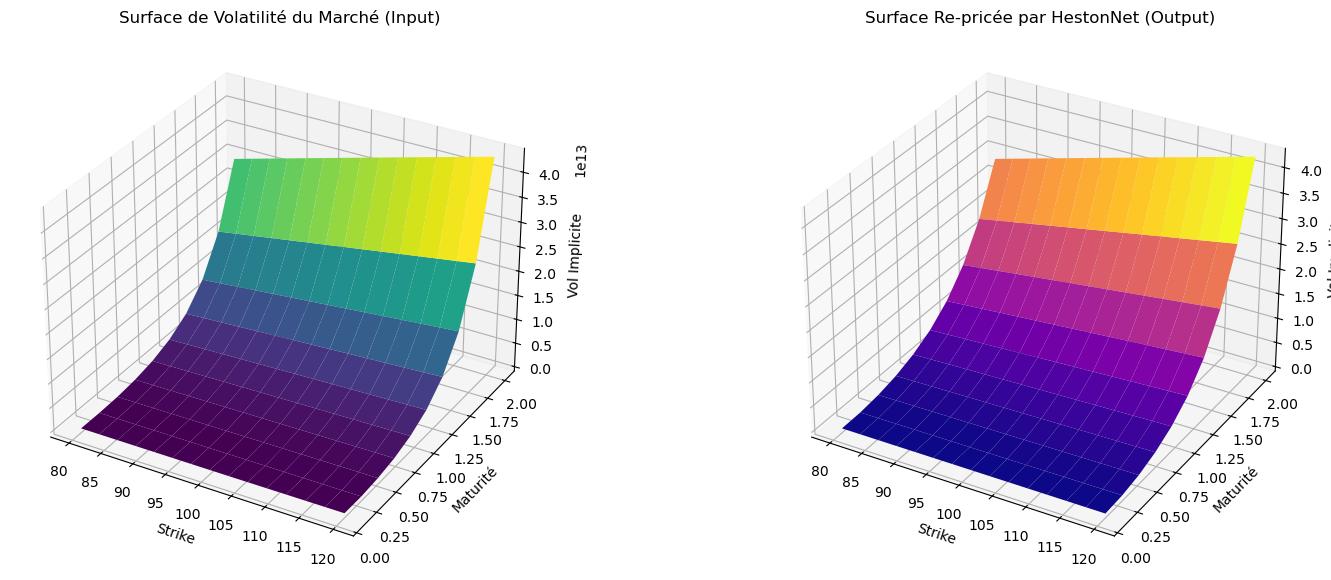

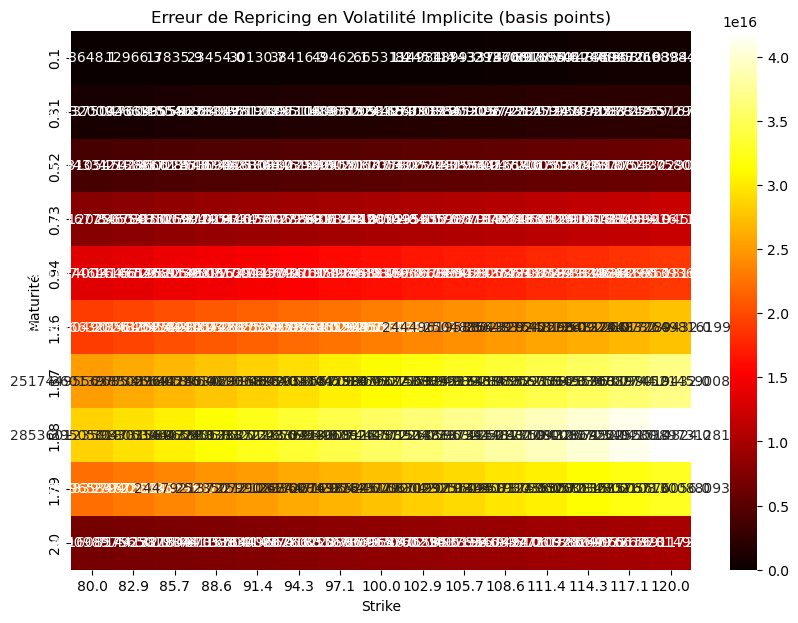

In [15]:
# ===================================================================
# ÉTAPE 7 : ÉVALUATION FINALE ET VISUALISATION (VERSION DÉFINITIVE)
# ===================================================================
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import time
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# --- DÉBUT DES FONCTIONS ORACLES NÉCESSAIRES ---
# S'assurer que ces fonctions sont bien définies ou recopiées ici
def heston_pricer_cos_vectorized(S0, K, T, r, v0, kappa, theta, gamma, rho, N=128, L=10):
    i = 1j
    S0, K, T, r, v0, kappa, theta, gamma, rho = map(np.atleast_1d, 
        [S0, K, T, r, v0, kappa, theta, gamma, rho])
    x0 = np.log(S0 / K)
    c1 = r * T + (1 - np.exp(-kappa * T)) * (theta - v0) / (2 * kappa) - 0.5 * theta * T
    with np.errstate(invalid='ignore'):
        c2 = (1/(8*kappa**3)) * (gamma*T*kappa*np.exp(-kappa*T)*(v0-theta)*(8*kappa*rho-4*gamma)+kappa*rho*gamma*(1-np.exp(-kappa*T))*(16*theta-8*v0)+2*theta*kappa*T*(-4*kappa*rho*gamma+gamma**2+4*kappa**2)+gamma**2*((theta-2*v0)*np.exp(-2*kappa*T)+theta*(6*np.exp(-kappa*T)-7)+2*v0)+8*kappa**2*(v0-theta)*(1-np.exp(-kappa*T)))
    a = c1 - L * np.sqrt(np.abs(c2))
    b = c1 + L * np.sqrt(np.abs(c2))
    k = np.arange(N)[:, np.newaxis]
    u = k * np.pi / (b - a)
    
    alpha = -0.5 * u * (u - i)
    beta = kappa - rho * gamma * u * i
    with np.errstate(invalid='ignore'):
        d = np.sqrt(beta**2 - 2 * alpha * gamma**2)
    g = (beta - d) / (beta + d)
    exp_d_T = np.exp(-d * T)
    log_denom = 1 - g
    log_denom[np.isclose(log_denom, 0)] = 1e-12
    
    with np.errstate(invalid='ignore'):
        C = r*u*i*T + (kappa*theta/gamma**2) * ((beta-d)*T - 2*np.log((1-g*exp_d_T)/log_denom))
        D = ((beta - d) / gamma**2) * ((1 - exp_d_T) / (1 - g * exp_d_T))
    
    cf = np.exp(C + D*v0 + i*u*np.log(S0))
    cf_adj = cf * np.exp(i*u*(x0-a))
    
    pi_k = k * np.pi
    H_k = (np.cos(pi_k) * np.exp(b) - np.exp(a) + pi_k * (np.sin(pi_k) * np.exp(b))) / (1 + pi_k**2)
    H_k[0] = (np.exp(b) - np.exp(a))
    H_k_minus_a = (-np.cos(pi_k) + np.exp(a) + pi_k * np.sin(pi_k)) / (1 + pi_k**2)
    H_k_minus_a[0] = -a
    
    V_k = 2 * K / (b - a) * (H_k - H_k_minus_a)
    sommation = np.real(cf_adj * V_k)
    sommation[0] *= 0.5
    price = np.exp(-r * T) * np.sum(sommation, axis=0)
    return price
# --- FIN DES FONCTIONS ORACLES ---


print("\\n--- ÉVALUATION VISUELLE DE LA CALIBRATION ---")
# On choisit un échantillon aléatoire dans l'ensemble de validation NON SCALÉ
idx = np.random.randint(0, X_val.shape[0])
market_iv_surface_raw = X_val[idx]
true_params_raw = y_val[idx]

# --- ÉTAPE CLÉ : On scale l'input UNIQUEMENT pour la prédiction ---
market_iv_surface_scaled_for_pred = iv_scaler.transform([market_iv_surface_raw])

# Prédiction avec le réseau de neurones
start_time_nn = time.time()
predicted_params_scaled = calibrator_model.predict(market_iv_surface_scaled_for_pred, verbose=0)
end_time_nn = time.time()

# "Dé-scaler" la sortie du modèle pour obtenir les paramètres Heston réels
predicted_params = params_scaler.inverse_transform(predicted_params_scaled)[0]

# Affichage des résultats
print(f"Calibration par HestonNet en {1000 * (end_time_nn - start_time_nn):.2f} ms")
print("-" * 50)
print(f"{'Paramètre':<10} | {'Vraie valeur':<15} | {'Valeur Prédite':<15}")
print("-" * 50)
labels = ['v0', 'kappa', 'theta', 'gamma', 'rho']
for i, label in enumerate(labels):
    print(f"{label:<10} | {true_params_raw[i]:<15.4f} | {predicted_params[i]:<15.4f}")
print("-" * 50)

# Re-pricing (utilise les fonctions oracles NumPy)
strikes_grid, maturities_grid = np.meshgrid(strikes, maturities)
strikes_flat = strikes_grid.flatten()
maturities_flat = maturities_grid.flatten()
S0_flat = np.full_like(strikes_flat, 100.0)
r_flat = np.full_like(strikes_flat, 0.01)

model_prices = heston_pricer_cos_vectorized(100.0, strikes_flat, maturities_flat, 0.01, *predicted_params)
model_ivs_repriced = implied_volatility_newton_vectorized(model_prices, S0_flat, strikes_flat, maturities_flat, r_flat).reshape(len(maturities), len(strikes))
market_iv_surface_2d = market_iv_surface_raw.reshape(len(maturities), len(strikes))

# Visualisation 3D
fig = plt.figure(figsize=(18, 7))
ax1 = fig.add_subplot(121, projection='3d')
X_mesh, Y_mesh = np.meshgrid(strikes, maturities)
ax1.plot_surface(X_mesh, Y_mesh, market_iv_surface_2d, cmap='viridis')
ax1.set_title('Surface de Volatilité du Marché (Input)')
ax1.set_xlabel('Strike'); ax1.set_ylabel('Maturité'); ax1.set_zlabel('Vol Implicite')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_mesh, Y_mesh, model_ivs_repriced, cmap='plasma')
ax2.set_title('Surface Re-pricée par HestonNet (Output)')
ax2.set_xlabel('Strike'); ax2.set_ylabel('Maturité'); ax2.set_zlabel('Vol Implicite')
plt.show()

# Heatmap des erreurs
error_iv = np.abs(model_ivs_repriced - market_iv_surface_2d) * 10000 # en bps
plt.figure(figsize=(10, 7))
sns.heatmap(error_iv, xticklabels=np.round(strikes, 1), yticklabels=np.round(maturities, 2), annot=True, fmt=".1f", cmap="hot")
plt.title("Erreur de Repricing en Volatilité Implicite (basis points)")
plt.xlabel("Strike"); plt.ylabel("Maturité")
plt.show()

\n--- ÉVALUATION VISUELLE DE LA CALIBRATION ---
Calibration par HestonNet en 84.89 ms
--------------------------------------------------
Paramètre  | Vraie valeur    | Valeur Prédite 
--------------------------------------------------
v0         | 0.1678          | 0.1642         
kappa      | 1.9037          | 2.9868         
theta      | 0.1547          | 0.1592         
gamma      | 0.5339          | 0.5534         
rho        | -0.6466         | -0.5145        
--------------------------------------------------


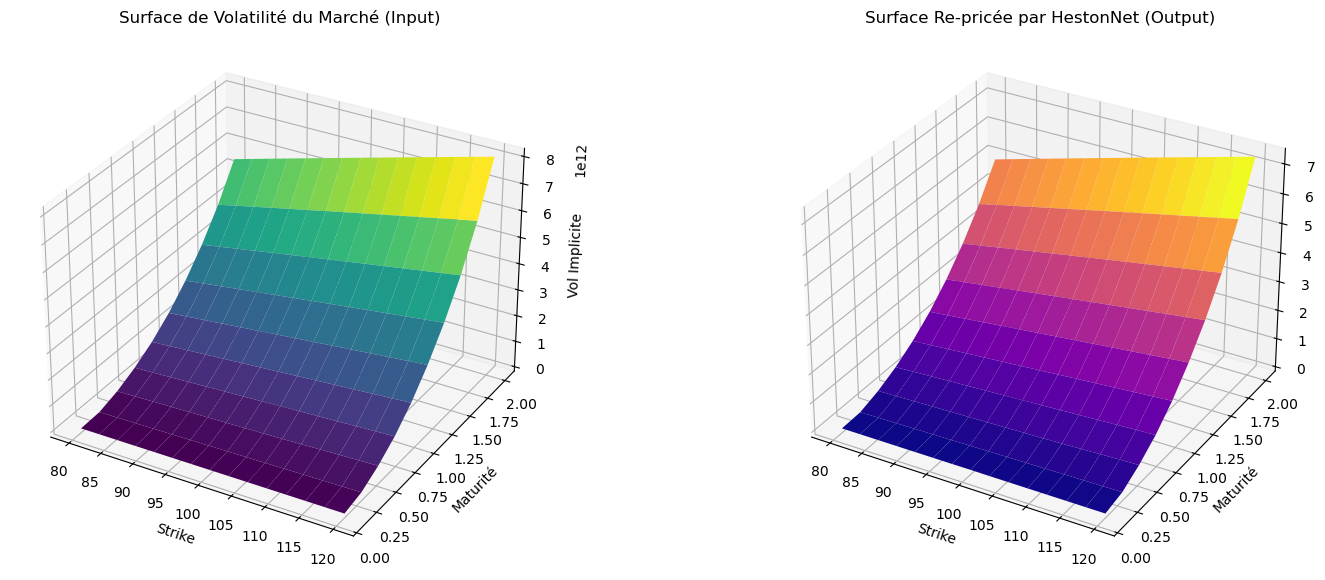

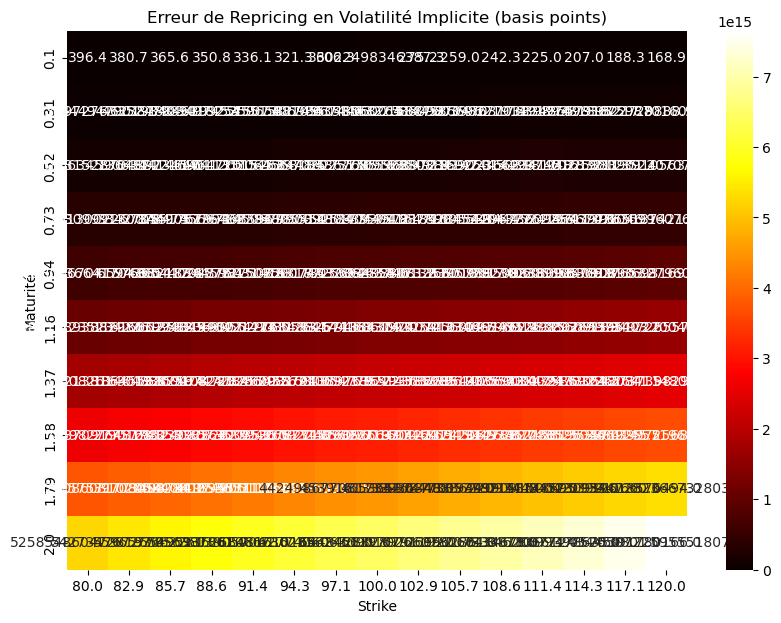

In [16]:
# ===================================================================
# ÉTAPE 7 : ÉVALUATION FINALE ET VISUALISATION (VERSION AUTONOME ET CORRIGÉE)
# ===================================================================
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import time
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm

# --- DÉBUT DES FONCTIONS ORACLES NÉCESSAIRES ---
# Ces fonctions sont maintenant locales à cette cellule pour éviter tout conflit.

def black_scholes_pricer_vectorized(S, K, T, r, sigma):
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        d1 = np.nan_to_num(d1, nan=0.0, posinf=np.inf, neginf=-np.inf)
        d2 = np.nan_to_num(d2, nan=0.0, posinf=np.inf, neginf=-np.inf)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_vega_vectorized(S, K, T, r, sigma):
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d1 = np.nan_to_num(d1, nan=0.0, posinf=np.inf, neginf=-np.inf)
    return S * norm.pdf(d1) * np.sqrt(T)

def implied_volatility_newton_vectorized(target_prices, S, K, T, r, max_iter=20, tol=1e-6):
    C = target_prices
    term1 = 2 * C - (S - K * np.exp(-r * T))
    term2 = (S - K * np.exp(-r * T))**2
    term3 = 4 * K * np.exp(-r * T) * C
    sigma = np.sqrt(2 * np.pi / T) * (term1 + np.sqrt(np.maximum(term2 + term3, 0))) / (2 * S)
    sigma = np.nan_to_num(sigma, nan=0.2)
    
    for _ in range(max_iter):
        price_guess = black_scholes_pricer_vectorized(S, K, T, r, sigma)
        vega = bs_vega_vectorized(S, K, T, r, sigma)
        error = price_guess - target_prices
        if np.max(np.abs(error)) < tol:
            break
        sigma = sigma - error / (vega + 1e-8)

    min_price = np.maximum(0, S - K * np.exp(-r * T))
    sigma[target_prices < min_price] = np.nan
    return sigma

def heston_pricer_cos_vectorized(S0, K, T, r, v0, kappa, theta, gamma, rho, N=128, L=10):
    i = 1j
    S0, K, T, r, v0, kappa, theta, gamma, rho = map(np.atleast_1d, 
        [S0, K, T, r, v0, kappa, theta, gamma, rho])
    x0 = np.log(S0 / K)
    with np.errstate(invalid='ignore'):
        c1 = r * T + (1 - np.exp(-kappa * T)) * (theta - v0) / (2 * kappa) - 0.5 * theta * T
        c2 = (1/(8*kappa**3)) * (gamma*T*kappa*np.exp(-kappa*T)*(v0-theta)*(8*kappa*rho-4*gamma)+kappa*rho*gamma*(1-np.exp(-kappa*T))*(16*theta-8*v0)+2*theta*kappa*T*(-4*kappa*rho*gamma+gamma**2+4*kappa**2)+gamma**2*((theta-2*v0)*np.exp(-2*kappa*T)+theta*(6*np.exp(-kappa*T)-7)+2*v0)+8*kappa**2*(v0-theta)*(1-np.exp(-kappa*T)))
    a = c1 - L * np.sqrt(np.abs(c2))
    b = c1 + L * np.sqrt(np.abs(c2))
    k = np.arange(N)[:, np.newaxis]
    u = k * np.pi / (b - a)
    
    alpha = -0.5 * u * (u - i)
    beta = kappa - rho * gamma * u * i
    with np.errstate(invalid='ignore'):
        d = np.sqrt(beta**2 - 2 * alpha * gamma**2)
    g = (beta - d) / (beta + d)
    exp_d_T = np.exp(-d * T)
    log_denom = 1 - g
    log_denom[np.isclose(log_denom, 0)] = 1e-12
    
    with np.errstate(invalid='ignore'):
        C = r*u*i*T + (kappa*theta/gamma**2) * ((beta-d)*T - 2*np.log((1-g*exp_d_T)/log_denom))
        D = ((beta - d) / gamma**2) * ((1 - exp_d_T) / (1 - g * exp_d_T))
    
    cf = np.exp(C + D*v0 + i*u*np.log(S0))
    cf_adj = cf * np.exp(i*u*(x0-a))
    
    pi_k = k * np.pi
    H_k = (np.cos(pi_k) * np.exp(b) - np.exp(a) + pi_k * (np.sin(pi_k) * np.exp(b))) / (1 + pi_k**2)
    H_k[0] = (np.exp(b) - np.exp(a))
    H_k_minus_a = (-np.cos(pi_k) + np.exp(a) + pi_k * np.sin(pi_k)) / (1 + pi_k**2)
    H_k_minus_a[0] = -a
    
    V_k = 2 * K / (b - a) * (H_k - H_k_minus_a)
    sommation = np.real(cf_adj * V_k)
    sommation[0] *= 0.5
    price = np.exp(-r * T) * np.sum(sommation, axis=0)
    return price
# --- FIN DES FONCTIONS ORACLES ---


print("\\n--- ÉVALUATION VISUELLE DE LA CALIBRATION ---")
# On choisit un échantillon aléatoire dans l'ensemble de validation NON SCALÉ
idx = np.random.randint(0, X_val.shape[0])
market_iv_surface_raw = X_val[idx]
true_params_raw = y_val[idx]

# On scale l'input UNIQUEMENT pour la prédiction
market_iv_surface_scaled_for_pred = iv_scaler.transform([market_iv_surface_raw])

# Prédiction avec le réseau de neurones
start_time_nn = time.time()
predicted_params_scaled = calibrator_model.predict(market_iv_surface_scaled_for_pred, verbose=0)
end_time_nn = time.time()

# "Dé-scaler" la sortie du modèle pour obtenir les paramètres Heston réels
predicted_params = params_scaler.inverse_transform(predicted_params_scaled)[0]

# Affichage des résultats
print(f"Calibration par HestonNet en {1000 * (end_time_nn - start_time_nn):.2f} ms")
print("-" * 50)
print(f"{'Paramètre':<10} | {'Vraie valeur':<15} | {'Valeur Prédite':<15}")
print("-" * 50)
labels = ['v0', 'kappa', 'theta', 'gamma', 'rho']
for i, label in enumerate(labels):
    print(f"{label:<10} | {true_params_raw[i]:<15.4f} | {predicted_params[i]:<15.4f}")
print("-" * 50)

# Re-pricing (utilise les fonctions oracles NumPy)
strikes_grid, maturities_grid = np.meshgrid(strikes, maturities)
strikes_flat = strikes_grid.flatten()
maturities_flat = maturities_grid.flatten()
S0_flat = np.full_like(strikes_flat, 100.0)
r_flat = np.full_like(strikes_flat, 0.01)

model_prices = heston_pricer_cos_vectorized(100.0, strikes_flat, maturities_flat, 0.01, *predicted_params)
model_ivs_repriced = implied_volatility_newton_vectorized(model_prices, S0_flat, strikes_flat, maturities_flat, r_flat).reshape(len(maturities), len(strikes))
market_iv_surface_2d = market_iv_surface_raw.reshape(len(maturities), len(strikes))

# Visualisation 3D
fig = plt.figure(figsize=(18, 7))
ax1 = fig.add_subplot(121, projection='3d')
X_mesh, Y_mesh = np.meshgrid(strikes, maturities)
ax1.plot_surface(X_mesh, Y_mesh, market_iv_surface_2d, cmap='viridis')
ax1.set_title('Surface de Volatilité du Marché (Input)')
ax1.set_xlabel('Strike'); ax1.set_ylabel('Maturité'); ax1.set_zlabel('Vol Implicite')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_mesh, Y_mesh, model_ivs_repriced, cmap='plasma')
ax2.set_title('Surface Re-pricée par HestonNet (Output)')
ax2.set_xlabel('Strike'); ax2.set_ylabel('Maturité'); ax2.set_zlabel('Vol Implicite')
plt.show()

# Heatmap des erreurs
error_iv = np.abs(model_ivs_repriced - market_iv_surface_2d) * 10000 # en bps
plt.figure(figsize=(10, 7))
sns.heatmap(error_iv, xticklabels=np.round(strikes, 1), yticklabels=np.round(maturities, 2), annot=True, fmt=".1f", cmap="hot")
plt.title("Erreur de Repricing en Volatilité Implicite (basis points)")
plt.xlabel("Strike"); plt.ylabel("Maturité")
plt.show()